# imports

In [660]:
from sklearn.metrics import get_scorer_names
import optuna 
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import learning_curve

#############################
import lightgbm as lgb
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
#################################
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectKBest, chi2
import warnings
warnings.filterwarnings('ignore')
import missingno as msno

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.inspection import permutation_importance
from sklearn.impute import KNNImputer
from sklearn.feature_selection import SelectKBest, f_classif

# Data loading

In [661]:
trainx = pd.read_csv('../input/playground-series-s3e22/train.csv')
test = pd.read_csv('../input/playground-series-s3e22/test.csv')
original = pd.read_csv('../input/horse-survival-dataset/horse.csv')
submission = pd.read_csv('../input/playground-series-s3e22/sample_submission.csv')

In [662]:
train = pd.concat([trainx, original], ignore_index=True)
train.drop_duplicates(inplace=True)
total = pd.concat([train, test], ignore_index=True)
target='outcome'

concatenating  the train dataset with the original dataset for later analysis to later check if it would positively affect the model performance ( update : it did )  

In [663]:
print('The dimension of the total dataset is:', total.shape)
print('The dimension of the test dataset is:', test.shape)
print('The dimension of the original train dataset is:', original.shape)
print('The dimension of the train dataset is:', trainx.shape)

The dimension of the total dataset is: (2358, 29)
The dimension of the test dataset is: (824, 28)
The dimension of the original train dataset is: (299, 28)
The dimension of the train dataset is: (1235, 29)


# EDA and preprocessing

0             died
2            lived
3            lived
6       euthanized
7             died
           ...    
1525          died
1526          died
1527    euthanized
1531          died
1532         lived
Name: outcome, Length: 827, dtype: object


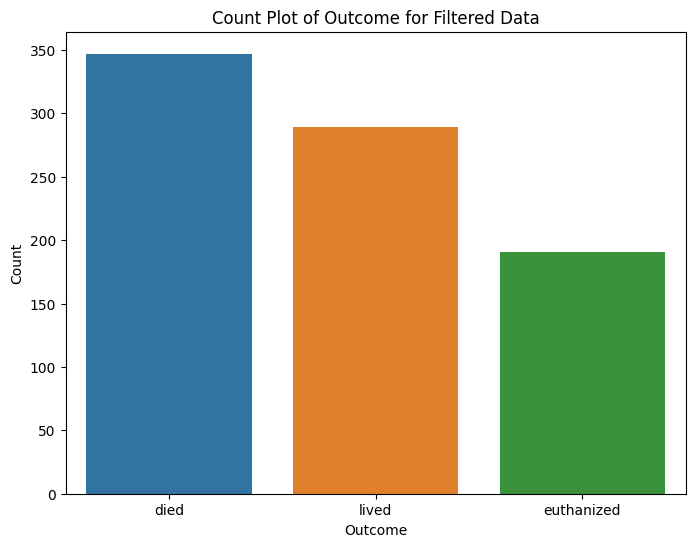

In [664]:

filtered_data = train[(train['peripheral_pulse'] =='reduced') ]


print(filtered_data['outcome'])
plt.figure(figsize=(8, 6))  
sns.countplot(data=filtered_data, x='outcome')


plt.xlabel('Outcome')
plt.ylabel('Count')
plt.title('Count Plot of Outcome for Filtered Data')


plt.show()

In [665]:
total.drop('id',axis=1,inplace=True)


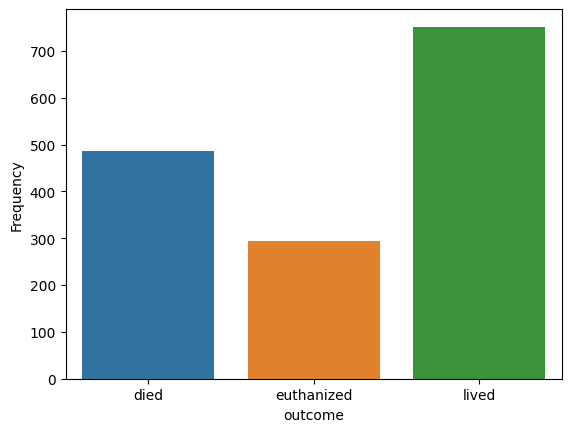

In [666]:
sns.countplot(data = total, x = 'outcome')
plt.ylabel('Frequency');

0->died

1->euthanized

2->lived

In [667]:

# # Criteria 1: Normal in abdominal_distention and severe in abdominal appearance
# criteria1_count = len(total[(total['abdominal_distention'] == 'slight') & (total['abdomo_appearance'] == 'clear')])

# # Criteria 2: Normal in abdominal_distention and cloudy in abdominal appearance
# criteria2_count = len(total[(total['abdominal_distention'] == 'normal') & (total['abdomo_appearance'] == 'cloudy')])

# # Criteria 3: Normal in abdominal_distention and serosanguinous in abdominal appearance
# criteria3_count = len(total[(total['abdominal_distention'] == 'severe') & (total['abdomo_appearance'] == 'serosanguinous')])

# # Print the outcomes
# print(f"Number of rows with 'slight' in abdominal_distention and 'clear' in abdominal appearance: {criteria1_count}")
# print(f"Number of rows with 'Normal' in abdominal_distention and 'Cloudy' in abdominal appearance: {criteria2_count}")
# print(f"Number of rows with 'severe' in abdominal_distention and 'Serosanguinous' in abdominal appearance: {criteria3_count}")

In [668]:
# # Assuming your DataFrame is named 'total' and the target variable is 'outcome'

# # Filter rows based on criteria
# filtered_rows = train[(train['abdominal_distention'] == 'severe') & (train['abdomo_appearance'] == 'cloudy')]

# # Create a histogram of the 'outcome' variable for the filtered rows
# plt.figure(figsize=(8, 6))
# sns.histplot(data=filtered_rows, x='outcome', bins=2, discrete=True)
# plt.xlabel("Outcome")
# plt.ylabel("Frequency")
# plt.title("Histogram of 'Outcome' Variable for Filtered Rows")
# plt.xticks([0, 1 ,2])  # Assuming binary outcome (0 and 1)
# plt.show()

In [669]:

# total.drop('cp_data',axis=1,inplace=True)

***removing CP data has worsen the model , which i expected after analysing the data , CP data has effectively helped with deciding if the horse needed to be euthanized or not ***

In [670]:
categorical_feats=[]


In [671]:
for column in total.columns:
  
    if total[column].dtype == 'object':
        
        categorical_feats.append(column)


print(categorical_feats)

['surgery', 'age', 'temp_of_extremities', 'peripheral_pulse', 'mucous_membrane', 'capillary_refill_time', 'pain', 'peristalsis', 'abdominal_distention', 'nasogastric_tube', 'nasogastric_reflux', 'rectal_exam_feces', 'abdomen', 'abdomo_appearance', 'surgical_lesion', 'cp_data', 'outcome']


In [672]:
categorical_feats.remove('outcome')

In [673]:
numerical_features = []


for column in total.columns:
    
    if pd.api.types.is_numeric_dtype(total[column]):
     
        numerical_features.append(column)


print(numerical_features)

['hospital_number', 'rectal_temp', 'pulse', 'respiratory_rate', 'nasogastric_reflux_ph', 'packed_cell_volume', 'total_protein', 'abdomo_protein', 'lesion_1', 'lesion_2', 'lesion_3']


In [674]:
pd.options.display.float_format = '{:,.2f}'.format
def summary(df):
    print(f'data shape: {df.shape}')
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['#missing'] = df.isnull().sum().values 
    summ['%missing'] = df.isnull().sum().values / len(df) * 100
    summ['#unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    summ['average'] = desc['mean'].values
    summ['standard_deviation'] = desc['std'].values
    summ['first value'] = df.loc[0].values
    summ['second value'] = df.loc[1].values
    summ['third value'] = df.loc[2].values
    
    return summ

In [675]:
summary(total).style.background_gradient(cmap='YlOrBr')

data shape: (2358, 28)


,data type,#missing,%missing,#unique,min,max,average,standard_deviation,first value,second value,third value
surgery,object,0,0.000000,2,nan,nan,nan,nan,yes,yes,yes
age,object,0,0.000000,2,nan,nan,nan,nan,adult,adult,adult
hospital_number,int64,0,0.000000,289,518476.000000,5305629.000000,1025159.628923,1452759.343805,530001,533836,529812
rectal_temp,float64,60,2.544529,43,35.400000,40.800000,38.213882,0.781971,38.100000,37.500000,38.300000
pulse,float64,24,1.017812,52,30.000000,184.000000,78.913025,29.173259,132.000000,88.000000,120.000000
respiratory_rate,float64,58,2.459712,43,8.000000,96.000000,30.335217,16.933441,24.000000,12.000000,28.000000
temp_of_extremities,object,130,5.513147,4,nan,nan,nan,nan,cool,cool,cool
peripheral_pulse,object,176,7.463953,4,nan,nan,nan,nan,reduced,normal,reduced
mucous_membrane,object,81,3.435115,6,nan,nan,nan,nan,dark_cyanotic,pale_cyanotic,pale_pink
capillary_refill_time,object,44,1.865988,3,nan,nan,nan,nan,more_3_sec,more_3_sec,less_3_sec


****there are some inconsistencies in the train data and test  , for example in pain there is slight  which doesnt exist in test data ( there is moderate instead )
rectal exam feces , there is serosanguious ( only 1 case ) which doesn't exist in test data ****

In [676]:
total["rectal_exam_feces"] = np.where(total["rectal_exam_feces"].isin(["serosanguious"]), total["rectal_exam_feces"].mode()[0], 
                                              total["rectal_exam_feces"])
total["pain"] = np.where(total["pain"].isin(["slight", "moderate"]), "mild_pain", total["pain"])
total["peristalsis"] = np.where(total["peristalsis"].isin(["distend_small"]), total["peristalsis"].mode()[0], 
                                              total["peristalsis"])

total["nasogastric_reflux"] = np.where(total["nasogastric_reflux"].isin(["slight"]), 
                                               total["nasogastric_reflux"].mode()[0],
                                               total["nasogastric_reflux"])



In [677]:
total['frequency'] = total['hospital_number'].map(total['hospital_number'].value_counts())

****as the original data states , hospital number is merely an indicator for how many times did a horse visit the hosipital ( it still doesn't make sense to me because after analysing the data  , alot of  hospital numbers has many cases marked dead , how can a horse die more than one time ? ) ****

In [678]:
total.drop('hospital_number' , axis =1 , inplace = True )

In [679]:
total['frequency']

0       20
1       16
2        2
3        3
4        9
        ..
2353    83
2354     9
2355     5
2356    35
2357    19
Name: frequency, Length: 2358, dtype: int64

****respiratory rate doesn't seem very good in influencing the outcome state for horses  
lesion 2 , lesion 3 are probably going to just add noise 
can work in total protein and packed cell volume to construct a feature which would be usefull , they seem some what well distributed ( if i have time i will work on this , if not i will just add my research  findings at the top i hope you find it useful :) )  
pulse is very solid as it seems , will probably be very effective indicator ****

****outliers on the other hand i can't seem to find a good solution for it (yet ) becuase for most features , there are too many of them everywhere in every category  to be considered "outliers" , tell me what you think **** 

In [680]:
# trainpl['Combined_Feature'] = trainpl['packed_cell_volume'] + trainpl['total_protein']

In [681]:
# plt.scatter(total['Combined_Feature'], total['outcome'], alpha=0.5)
# plt.xlabel('Combined Feature')
# plt.ylabel('Target_Variable')
# plt.title('Scatter Plot: Combined Feature vs. Target Variable')
# plt.show()

In [682]:
# correlation_matrix2 = trainpl[['Combined_Feature', 'outcome']].corr()

In [683]:
# sns.heatmap(correlation_matrix2, annot=True, cmap='coolwarm')
# plt.title('Correlation Heatmap')
# plt.show()


In [684]:
def IQR(col):
    q1 = np.percentile(col, 25)
    q3 = np.percentile(col, 75)
    iqr = q3 - q1
    upper_bound = q3 + (1.5 * iqr)
    upper_outliers = col > upper_bound

    # Replace outliers with upper bound values
    col = np.where(upper_outliers, round(upper_bound, 2), col)  
    return col


total["total_protein"] = IQR(total["total_protein"])



In [685]:
# total['pcv_tp_ratio']=total['packed_cell_volume']/total['total_protein']

In [686]:
# print(train[train['lesion_1'] ==11300 ]['outcome'].value_counts())

In [687]:
# train[train['lesion_1'] > 9999]['lesion_1'].value_counts()

In [688]:

total['lesion_1'] = total['lesion_1'].astype(str)
site_of_lesion_mapping = {
    '1': 'gastric',
    '2': 'small intestine',
    '3': 'large colon',
    '4': 'large colon and cecum',
    '5': 'cecum',
    '6': 'transverse colon',
    '7': 'rectum/descending colon',
    '8': 'uterus',
    '9': 'bladder',
    '11': 'all intestinal sites',
    '0': 'none',
}

type_mapping = {
    '1': 'simple',
    '2': 'strangulation',
    '3': 'inflammation',
    '4': 'other',
}

subtype_mapping = {
    '1': 'mechanical',
    '2': 'paralytic',
    '0': 'n/a',
}

specific_code_mapping = {
    '1': 'obturation',
    '2': 'intrinsic',
    '3': 'extrinsic',
    '4': 'adynamic',
    '5': 'volvulus/torsion',
    '6': 'intussusception',
    '7': 'thromboembolic',
    '8': 'hernia',
    '9': 'lipoma/splenic incarceration',
    '10': 'displacement',
    '0': 'n/a',
}


total['site'] = total['lesion_1'].str[0].map(site_of_lesion_mapping)
total['type'] = total['lesion_1'].str[1].map(type_mapping)
total['subtype'] = total['lesion_1'].str[2].map(subtype_mapping)
total['specific_code'] = total['lesion_1'].str[3].map(specific_code_mapping)
special_cases = {
    '31110': ('large colon', 'simple', 'mechanical', 'displacement'),
    '12208': ('small intestine', 'strangulation', 'n/a', 'hernia'),
    '11300': ('gastric', 'simple', 'n/a', 'n/a'),
    '11400': ('all intestinal sites', 'other', 'n/a', 'n/a'),
    '11124': ('all intestinal sites', 'simple', 'paralytic', 'adynamic'),
    '21110': ('small intestine', 'simple', 'mechanical', 'displacement'),
    '41110': ('large colon and cecum', 'simple', 'mechanical', 'displacement'),
}


for case, (site, type, subtype, specific_code) in special_cases.items():
    total.loc[total['lesion_1'] == case, 'site'] = site
    total.loc[total['lesion_1'] == case, 'type'] = type
    total.loc[total['lesion_1'] == case, 'subtype'] = subtype
    total.loc[total['lesion_1'] == case, 'specific_code'] = specific_code

total.drop(['lesion_1', 'lesion_2', 'lesion_3'], axis=1, inplace=True)


****decoding lesion as the original dataset  clarified  ( update : subtype doesn't seem to be relevant to the outcome , dropping it proved to be worth , as for lesion 2 and 3  they have very little cases ) ****

In [689]:
total['site'].value_counts()

site
small intestine            1016
large colon                 577
none                        209
large colon and cecum       165
gastric                     113
cecum                       112
rectum/descending colon     101
uterus                       22
transverse colon             21
all intestinal sites         12
bladder                      10
Name: count, dtype: int64

In [690]:
total["outcome"] = total["outcome"].map({'died': 1,'euthanized': 0, 'lived':2})
categorical_feats = []
for column in total.columns:
   
    if total[column].dtype == 'object':
    
        categorical_feats.append(column)
        
print(categorical_feats)

['surgery', 'age', 'temp_of_extremities', 'peripheral_pulse', 'mucous_membrane', 'capillary_refill_time', 'pain', 'peristalsis', 'abdominal_distention', 'nasogastric_tube', 'nasogastric_reflux', 'rectal_exam_feces', 'abdomen', 'abdomo_appearance', 'surgical_lesion', 'cp_data', 'site', 'type', 'subtype', 'specific_code']


In [691]:
numerical_features = []


for column in total.columns:
    
    if pd.api.types.is_numeric_dtype(total[column]):
        if column != 'outcome':
            numerical_features.append(column)


print(numerical_features)

['rectal_temp', 'pulse', 'respiratory_rate', 'nasogastric_reflux_ph', 'packed_cell_volume', 'total_protein', 'abdomo_protein', 'frequency']


In [692]:
imputer = KNNImputer(n_neighbors=8)  
total[numerical_features] = imputer.fit_transform(total[numerical_features])

In [693]:
columns_to_fill = ['capillary_refill_time', 'nasogastric_reflux', 'peristalsis', 'mucous_membrane', 'abdominal_distention', 'pain', 'temp_of_extremities', 'abdomo_appearance', 'peripheral_pulse', 'nasogastric_tube', 'rectal_exam_feces', 'abdomen', 'type', 'subtype', 'specific_code']

In [694]:
total

,surgery,age,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,...,abdomo_appearance,abdomo_protein,surgical_lesion,cp_data,outcome,frequency,site,type,subtype,specific_code
0,yes,adult,38.10,132.00,24.00,cool,reduced,dark_cyanotic,more_3_sec,depressed,...,serosanguious,3.40,yes,no,1.00,20.00,small intestine,strangulation,n/a,lipoma/splenic incarceration
1,yes,adult,37.50,88.00,12.00,cool,normal,pale_cyanotic,more_3_sec,mild_pain,...,serosanguious,2.00,yes,no,0.00,16.00,small intestine,strangulation,n/a,hernia
2,yes,adult,38.30,120.00,28.00,cool,reduced,pale_pink,less_3_sec,extreme_pain,...,serosanguious,3.40,yes,no,2.00,2.00,cecum,simple,paralytic,adynamic
3,yes,adult,37.10,72.00,30.00,cold,reduced,pale_pink,more_3_sec,mild_pain,...,cloudy,3.90,yes,yes,2.00,3.00,small intestine,strangulation,n/a,hernia
4,no,adult,38.00,52.00,48.00,normal,normal,normal_pink,less_3_sec,alert,...,cloudy,2.60,no,yes,2.00,9.00,none,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2353,no,adult,40.30,114.00,36.00,cool,reduced,normal_pink,more_3_sec,depressed,...,serosanguious,4.50,yes,yes,NaN,83.00,large colon,strangulation,n/a,volvulus/torsion
2354,yes,adult,37.20,100.00,20.00,cool,reduced,pale_cyanotic,more_3_sec,extreme_pain,...,serosanguious,2.00,yes,no,NaN,9.00,small intestine,strangulation,n/a,lipoma/splenic incarceration
2355,yes,adult,39.20,132.00,12.00,cool,reduced,dark_cyanotic,more_3_sec,depressed,...,serosanguious,4.50,yes,no,NaN,5.00,small intestine,strangulation,n/a,volvulus/torsion
2356,no,adult,38.30,54.00,66.00,normal,normal,normal_pink,less_3_sec,mild_pain,...,clear,5.00,no,yes,NaN,35.00,large colon,simple,mechanical,obturation


In [695]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoder = LabelEncoder()
for column in columns_to_fill:
    column_not_null_firstly = total[total[column].notnull()].copy()
    column_not_null = column_not_null_firstly.copy()
    column_null_firstly = total[total[column].isnull()].copy()
    column_null = column_null_firstly.copy()
    
    column_not_null_self = pd.DataFrame(encoder.fit_transform(column_not_null[column]), columns=[column])
    column_not_null.drop(numerical_features + [column], axis=1, inplace=True)
    column_not_null = pd.DataFrame(ohe.fit_transform(column_not_null))
    column_not_null.columns = ohe.get_feature_names_out()
    column_not_null = pd.concat([column_not_null, column_not_null_firstly[numerical_features].reset_index(drop=True)], axis=1)

    column_null.drop(numerical_features + [column], axis=1, inplace=True)
    column_null = pd.DataFrame(ohe.fit_transform(column_null), columns=ohe.get_feature_names_out())
    column_null = pd.concat([column_null, column_null_firstly[numerical_features].reset_index(drop=True)], axis=1)    
    
    column_dependences = list(set(column_null.columns).intersection(set(column_not_null.columns)) - set(['outcome_0', 'outcome_1', 'outcome_2', 'outcome_3']))
    column_X_train, column_X_test, column_y_train, column_y_test = train_test_split(column_not_null[column_dependences], column_not_null_self, test_size=0.2, random_state=21, stratify=column_not_null_self)
    def objective(trial): 
        param = {  
        'loss': 'log_loss',
        'max_iter': trial.suggest_int('max_iter', 30, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3),
        'max_depth': trial.suggest_int('max_depth', 2, 25),
        'scoring': 'f1_micro',
        'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 2, 80),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 50),
        'l2_regularization': trial.suggest_float('l2_regularization', 0, 1),
        'warm_start': False,
        'early_stopping': 'auto',
        'scoring': 'loss',
        }
    
        model = HistGradientBoostingClassifier(**param).fit(column_X_train, np.ravel(column_y_train))  
        result = accuracy_score(column_y_test,(model.predict(column_X_test)))
        return result
        
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=20, n_jobs = -1, show_progress_bar = True)
    best_params = study.best_params
    best_accuracy = study.best_value
    print('Current column: ', column)
    print("Best Parameters: ", best_params)
    print("Best Accuracy: ", best_accuracy)
    
    xgb_column = HistGradientBoostingClassifier(**best_params)
    xgb_column.fit(column_X_train, column_y_train)
    y_pred = xgb_column.predict(column_X_test)
    accuracy = accuracy_score(y_pred, column_y_test)
    
    y_pred_proba_null = xgb_column.predict_proba(column_null[column_dependences])[:, 1]
    final_pred = xgb_column.predict(column_null[column_dependences])
    
    ###  taking only predictions with the best confidence (othes will be filled with mode)
    threshold = np.percentile(y_pred_proba_null, 0)
    
    final_pred_labels = encoder.inverse_transform(final_pred)
    
    final_pred_confident = np.where(y_pred_proba_null >= threshold, final_pred_labels, np.nan)
    total.loc[total[column].isnull(), column] = final_pred_confident
print(total)
print(total.columns)


[I 2023-10-02 16:23:33,467] A new study created in memory with name: no-name-2617d670-21df-4151-b569-0478b831195d


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2023-10-02 16:23:35,260] Trial 2 finished with value: 0.7667386609071274 and parameters: {'max_iter': 30, 'learning_rate': 0.16464630185722573, 'max_depth': 18, 'max_leaf_nodes': 15, 'min_samples_leaf': 34, 'l2_regularization': 0.019389625853240555}. Best is trial 2 with value: 0.7667386609071274.
[I 2023-10-02 16:23:40,050] Trial 3 finished with value: 0.7732181425485961 and parameters: {'max_iter': 91, 'learning_rate': 0.06337061810874905, 'max_depth': 21, 'max_leaf_nodes': 43, 'min_samples_leaf': 50, 'l2_regularization': 0.745381973980237}. Best is trial 3 with value: 0.7732181425485961.
[I 2023-10-02 16:23:42,586] Trial 4 finished with value: 0.7688984881209503 and parameters: {'max_iter': 100, 'learning_rate': 0.08194628798040535, 'max_depth': 12, 'max_leaf_nodes': 68, 'min_samples_leaf': 48, 'l2_regularization': 0.046922153960999746}. Best is trial 3 with value: 0.7732181425485961.
[I 2023-10-02 16:23:45,836] Trial 0 finished with value: 0.755939524838013 and parameters: {'max

[I 2023-10-02 16:25:02,442] A new study created in memory with name: no-name-b151a8b5-b62b-472e-b773-4545975571ef


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2023-10-02 16:25:16,844] Trial 2 finished with value: 0.6036036036036037 and parameters: {'max_iter': 291, 'learning_rate': 0.059355709641327616, 'max_depth': 4, 'max_leaf_nodes': 75, 'min_samples_leaf': 6, 'l2_regularization': 0.43120560739526426}. Best is trial 2 with value: 0.6036036036036037.
[I 2023-10-02 16:25:17,430] Trial 3 finished with value: 0.6126126126126126 and parameters: {'max_iter': 131, 'learning_rate': 0.23549873908059368, 'max_depth': 18, 'max_leaf_nodes': 29, 'min_samples_leaf': 33, 'l2_regularization': 0.6128483734204553}. Best is trial 3 with value: 0.6126126126126126.
[I 2023-10-02 16:25:20,167] Trial 5 finished with value: 0.6081081081081081 and parameters: {'max_iter': 52, 'learning_rate': 0.016293902576921884, 'max_depth': 10, 'max_leaf_nodes': 9, 'min_samples_leaf': 47, 'l2_regularization': 0.4206126554991144}. Best is trial 3 with value: 0.6126126126126126.
[I 2023-10-02 16:25:22,370] Trial 1 finished with value: 0.6103603603603603 and parameters: {'max_

[I 2023-10-02 16:26:03,188] A new study created in memory with name: no-name-f7328dbf-82ca-40aa-aba2-6a0bf793b2a5


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2023-10-02 16:26:11,006] Trial 1 finished with value: 0.7604395604395604 and parameters: {'max_iter': 69, 'learning_rate': 0.09178692655323739, 'max_depth': 19, 'max_leaf_nodes': 49, 'min_samples_leaf': 47, 'l2_regularization': 0.7368468585744922}. Best is trial 1 with value: 0.7604395604395604.
[I 2023-10-02 16:26:19,897] Trial 4 finished with value: 0.7516483516483516 and parameters: {'max_iter': 299, 'learning_rate': 0.24418869184431655, 'max_depth': 2, 'max_leaf_nodes': 5, 'min_samples_leaf': 42, 'l2_regularization': 0.2173788076176787}. Best is trial 1 with value: 0.7604395604395604.
[I 2023-10-02 16:26:20,848] Trial 0 finished with value: 0.7516483516483516 and parameters: {'max_iter': 203, 'learning_rate': 0.03732301642607429, 'max_depth': 7, 'max_leaf_nodes': 51, 'min_samples_leaf': 47, 'l2_regularization': 0.3721948555391241}. Best is trial 1 with value: 0.7604395604395604.
[I 2023-10-02 16:26:23,794] Trial 2 finished with value: 0.7582417582417582 and parameters: {'max_ite

[I 2023-10-02 16:27:39,389] A new study created in memory with name: no-name-a296b325-db85-4abb-89e9-bacd3ba40d54


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2023-10-02 16:27:41,048] Trial 1 finished with value: 0.5394736842105263 and parameters: {'max_iter': 38, 'learning_rate': 0.19003843779136095, 'max_depth': 2, 'max_leaf_nodes': 71, 'min_samples_leaf': 19, 'l2_regularization': 0.8867044367301717}. Best is trial 1 with value: 0.5394736842105263.
[I 2023-10-02 16:28:07,427] Trial 0 finished with value: 0.5328947368421053 and parameters: {'max_iter': 193, 'learning_rate': 0.2882414502501859, 'max_depth': 8, 'max_leaf_nodes': 16, 'min_samples_leaf': 2, 'l2_regularization': 0.39853620466340134}. Best is trial 1 with value: 0.5394736842105263.
[I 2023-10-02 16:28:16,809] Trial 4 finished with value: 0.5416666666666666 and parameters: {'max_iter': 188, 'learning_rate': 0.03581490624062013, 'max_depth': 13, 'max_leaf_nodes': 22, 'min_samples_leaf': 2, 'l2_regularization': 0.604324933722333}. Best is trial 4 with value: 0.5416666666666666.
[I 2023-10-02 16:28:30,731] Trial 2 finished with value: 0.5328947368421053 and parameters: {'max_iter'

[I 2023-10-02 16:31:11,000] A new study created in memory with name: no-name-40713b8d-3777-4c86-a489-6321b06c8934


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2023-10-02 16:31:14,362] Trial 3 finished with value: 0.5862831858407079 and parameters: {'max_iter': 41, 'learning_rate': 0.12916470870306146, 'max_depth': 13, 'max_leaf_nodes': 13, 'min_samples_leaf': 44, 'l2_regularization': 0.6661365890280785}. Best is trial 3 with value: 0.5862831858407079.
[I 2023-10-02 16:31:26,683] Trial 0 finished with value: 0.5575221238938053 and parameters: {'max_iter': 72, 'learning_rate': 0.019118860973154336, 'max_depth': 20, 'max_leaf_nodes': 41, 'min_samples_leaf': 8, 'l2_regularization': 0.982650927731724}. Best is trial 3 with value: 0.5862831858407079.
[I 2023-10-02 16:31:27,954] Trial 1 finished with value: 0.5973451327433629 and parameters: {'max_iter': 193, 'learning_rate': 0.12785351109600993, 'max_depth': 15, 'max_leaf_nodes': 16, 'min_samples_leaf': 31, 'l2_regularization': 0.559280967258774}. Best is trial 1 with value: 0.5973451327433629.
[I 2023-10-02 16:31:36,518] Trial 2 finished with value: 0.5929203539823009 and parameters: {'max_ite

[I 2023-10-02 16:33:04,401] A new study created in memory with name: no-name-8308cede-1544-40b8-918d-85717083adb3


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2023-10-02 16:33:15,550] Trial 2 finished with value: 0.6300448430493274 and parameters: {'max_iter': 76, 'learning_rate': 0.04975992568237504, 'max_depth': 20, 'max_leaf_nodes': 55, 'min_samples_leaf': 44, 'l2_regularization': 0.7564023994770652}. Best is trial 2 with value: 0.6300448430493274.
[I 2023-10-02 16:33:19,136] Trial 3 finished with value: 0.5986547085201793 and parameters: {'max_iter': 106, 'learning_rate': 0.29723249081971254, 'max_depth': 10, 'max_leaf_nodes': 20, 'min_samples_leaf': 12, 'l2_regularization': 0.09920819498490452}. Best is trial 2 with value: 0.6300448430493274.
[I 2023-10-02 16:33:21,584] Trial 0 finished with value: 0.594170403587444 and parameters: {'max_iter': 111, 'learning_rate': 0.24486202014029235, 'max_depth': 16, 'max_leaf_nodes': 73, 'min_samples_leaf': 43, 'l2_regularization': 0.15600168791306213}. Best is trial 2 with value: 0.6300448430493274.
[I 2023-10-02 16:33:22,091] Trial 1 finished with value: 0.6031390134529148 and parameters: {'max

[I 2023-10-02 16:35:13,076] A new study created in memory with name: no-name-698c60bf-955d-4a3c-a185-55c23912f063


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2023-10-02 16:35:15,947] Trial 3 finished with value: 0.6434977578475336 and parameters: {'max_iter': 70, 'learning_rate': 0.2229999269649512, 'max_depth': 3, 'max_leaf_nodes': 66, 'min_samples_leaf': 35, 'l2_regularization': 0.9123420959354626}. Best is trial 3 with value: 0.6434977578475336.
[I 2023-10-02 16:35:33,349] Trial 0 finished with value: 0.6322869955156951 and parameters: {'max_iter': 240, 'learning_rate': 0.16473042665062176, 'max_depth': 20, 'max_leaf_nodes': 15, 'min_samples_leaf': 43, 'l2_regularization': 0.324689351645571}. Best is trial 3 with value: 0.6434977578475336.
[I 2023-10-02 16:35:37,816] Trial 5 finished with value: 0.6569506726457399 and parameters: {'max_iter': 157, 'learning_rate': 0.052890500561450816, 'max_depth': 2, 'max_leaf_nodes': 50, 'min_samples_leaf': 37, 'l2_regularization': 0.4073722777197145}. Best is trial 5 with value: 0.6569506726457399.
[I 2023-10-02 16:35:41,200] Trial 2 finished with value: 0.6591928251121076 and parameters: {'max_ite

[I 2023-10-02 16:37:18,692] A new study created in memory with name: no-name-9298f415-78c0-4702-bbfd-70db29b5918e


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2023-10-02 16:37:22,845] Trial 3 finished with value: 0.6666666666666666 and parameters: {'max_iter': 144, 'learning_rate': 0.14432296448087317, 'max_depth': 7, 'max_leaf_nodes': 5, 'min_samples_leaf': 41, 'l2_regularization': 0.519562114266474}. Best is trial 3 with value: 0.6666666666666666.
[I 2023-10-02 16:37:22,876] Trial 0 finished with value: 0.6761229314420804 and parameters: {'max_iter': 291, 'learning_rate': 0.03583463097155569, 'max_depth': 8, 'max_leaf_nodes': 2, 'min_samples_leaf': 19, 'l2_regularization': 0.9913070810515635}. Best is trial 0 with value: 0.6761229314420804.
[I 2023-10-02 16:37:28,063] Trial 4 finished with value: 0.6737588652482269 and parameters: {'max_iter': 60, 'learning_rate': 0.289115409860867, 'max_depth': 20, 'max_leaf_nodes': 27, 'min_samples_leaf': 50, 'l2_regularization': 0.41623579921358567}. Best is trial 0 with value: 0.6761229314420804.
[I 2023-10-02 16:37:29,514] Trial 1 finished with value: 0.6737588652482269 and parameters: {'max_iter':

[I 2023-10-02 16:38:22,301] A new study created in memory with name: no-name-c85fe9ce-2c3a-4b27-9d76-6f75be6af871


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2023-10-02 16:38:25,791] Trial 3 finished with value: 0.8054919908466819 and parameters: {'max_iter': 45, 'learning_rate': 0.020945338645258063, 'max_depth': 7, 'max_leaf_nodes': 18, 'min_samples_leaf': 50, 'l2_regularization': 0.03404802647330796}. Best is trial 3 with value: 0.8054919908466819.
[I 2023-10-02 16:38:29,463] Trial 4 finished with value: 0.8237986270022883 and parameters: {'max_iter': 130, 'learning_rate': 0.15625037258764202, 'max_depth': 2, 'max_leaf_nodes': 32, 'min_samples_leaf': 41, 'l2_regularization': 0.2606014307559854}. Best is trial 4 with value: 0.8237986270022883.
[I 2023-10-02 16:38:30,476] Trial 0 finished with value: 0.8283752860411899 and parameters: {'max_iter': 77, 'learning_rate': 0.0333247682573096, 'max_depth': 13, 'max_leaf_nodes': 20, 'min_samples_leaf': 11, 'l2_regularization': 0.01775308937100506}. Best is trial 0 with value: 0.8283752860411899.
[I 2023-10-02 16:38:33,488] Trial 5 finished with value: 0.8329519450800915 and parameters: {'max_i

[I 2023-10-02 16:39:51,077] A new study created in memory with name: no-name-8ef13f5f-e9e3-418b-9fd5-915754398a89


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2023-10-02 16:39:52,192] Trial 2 finished with value: 0.6824644549763034 and parameters: {'max_iter': 49, 'learning_rate': 0.11176802466375277, 'max_depth': 2, 'max_leaf_nodes': 65, 'min_samples_leaf': 32, 'l2_regularization': 0.5050286940978512}. Best is trial 2 with value: 0.6824644549763034.
[I 2023-10-02 16:39:54,378] Trial 1 finished with value: 0.6635071090047393 and parameters: {'max_iter': 135, 'learning_rate': 0.09224292383311605, 'max_depth': 3, 'max_leaf_nodes': 4, 'min_samples_leaf': 9, 'l2_regularization': 0.2882943706733503}. Best is trial 2 with value: 0.6824644549763034.
[I 2023-10-02 16:39:58,841] Trial 5 finished with value: 0.6848341232227488 and parameters: {'max_iter': 73, 'learning_rate': 0.24649370671341772, 'max_depth': 5, 'max_leaf_nodes': 60, 'min_samples_leaf': 9, 'l2_regularization': 0.055713005670105176}. Best is trial 5 with value: 0.6848341232227488.
[I 2023-10-02 16:39:59,979] Trial 0 finished with value: 0.6777251184834123 and parameters: {'max_iter'

[I 2023-10-02 16:41:27,698] A new study created in memory with name: no-name-6c05a2fa-62b3-4f2f-ace6-fe30275e8deb


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2023-10-02 16:41:42,603] Trial 0 finished with value: 0.6298200514138818 and parameters: {'max_iter': 211, 'learning_rate': 0.25837221847958475, 'max_depth': 16, 'max_leaf_nodes': 12, 'min_samples_leaf': 10, 'l2_regularization': 0.0675095471471171}. Best is trial 0 with value: 0.6298200514138818.
[I 2023-10-02 16:41:46,328] Trial 1 finished with value: 0.6426735218508998 and parameters: {'max_iter': 59, 'learning_rate': 0.13061872734187743, 'max_depth': 12, 'max_leaf_nodes': 72, 'min_samples_leaf': 5, 'l2_regularization': 0.8777767757136506}. Best is trial 1 with value: 0.6426735218508998.
[I 2023-10-02 16:41:48,382] Trial 3 finished with value: 0.6580976863753213 and parameters: {'max_iter': 146, 'learning_rate': 0.0530612821950686, 'max_depth': 13, 'max_leaf_nodes': 47, 'min_samples_leaf': 29, 'l2_regularization': 0.6999417684843576}. Best is trial 3 with value: 0.6580976863753213.
[I 2023-10-02 16:41:59,927] Trial 6 finished with value: 0.6632390745501285 and parameters: {'max_it

[I 2023-10-02 16:43:12,102] A new study created in memory with name: no-name-34134b83-3088-4f45-9208-01bb778141ec


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2023-10-02 16:43:14,271] Trial 1 finished with value: 0.752 and parameters: {'max_iter': 64, 'learning_rate': 0.041455694450813374, 'max_depth': 2, 'max_leaf_nodes': 7, 'min_samples_leaf': 12, 'l2_regularization': 0.8080974542449705}. Best is trial 1 with value: 0.752.
[I 2023-10-02 16:43:15,307] Trial 0 finished with value: 0.7493333333333333 and parameters: {'max_iter': 146, 'learning_rate': 0.08880074804389967, 'max_depth': 16, 'max_leaf_nodes': 2, 'min_samples_leaf': 16, 'l2_regularization': 0.339251162242757}. Best is trial 1 with value: 0.752.
[I 2023-10-02 16:43:16,656] Trial 5 finished with value: 0.7653333333333333 and parameters: {'max_iter': 41, 'learning_rate': 0.2857727060649253, 'max_depth': 2, 'max_leaf_nodes': 75, 'min_samples_leaf': 35, 'l2_regularization': 0.16499159016149012}. Best is trial 5 with value: 0.7653333333333333.
[I 2023-10-02 16:43:26,842] Trial 2 finished with value: 0.7413333333333333 and parameters: {'max_iter': 284, 'learning_rate': 0.2521119104706

[I 2023-10-02 16:44:29,358] A new study created in memory with name: no-name-f62d81fe-2b33-443d-96ad-808111fa43ed


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2023-10-02 16:44:44,721] Trial 0 finished with value: 0.9879807692307693 and parameters: {'max_iter': 221, 'learning_rate': 0.14986774897719635, 'max_depth': 8, 'max_leaf_nodes': 43, 'min_samples_leaf': 25, 'l2_regularization': 0.7495978515492958}. Best is trial 0 with value: 0.9879807692307693.
[I 2023-10-02 16:44:46,090] Trial 1 finished with value: 0.9831730769230769 and parameters: {'max_iter': 229, 'learning_rate': 0.25121700909387545, 'max_depth': 19, 'max_leaf_nodes': 46, 'min_samples_leaf': 22, 'l2_regularization': 0.9256274708297236}. Best is trial 0 with value: 0.9879807692307693.
[I 2023-10-02 16:44:48,239] Trial 4 finished with value: 0.9855769230769231 and parameters: {'max_iter': 105, 'learning_rate': 0.18101384774931265, 'max_depth': 3, 'max_leaf_nodes': 32, 'min_samples_leaf': 21, 'l2_regularization': 0.21009004806250509}. Best is trial 0 with value: 0.9879807692307693.
[I 2023-10-02 16:44:48,336] Trial 3 finished with value: 0.9831730769230769 and parameters: {'max_

[I 2023-10-02 16:45:32,232] A new study created in memory with name: no-name-4c774f37-1867-430c-96ca-7aa054bfe0a1


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2023-10-02 16:45:37,607] Trial 1 finished with value: 0.951048951048951 and parameters: {'max_iter': 87, 'learning_rate': 0.2871397483133162, 'max_depth': 8, 'max_leaf_nodes': 28, 'min_samples_leaf': 28, 'l2_regularization': 0.4650645357113956}. Best is trial 1 with value: 0.951048951048951.
[I 2023-10-02 16:45:38,696] Trial 4 finished with value: 0.9533799533799534 and parameters: {'max_iter': 62, 'learning_rate': 0.2471626214298992, 'max_depth': 2, 'max_leaf_nodes': 6, 'min_samples_leaf': 47, 'l2_regularization': 0.7382541466542245}. Best is trial 4 with value: 0.9533799533799534.
[I 2023-10-02 16:45:40,876] Trial 0 finished with value: 0.9487179487179487 and parameters: {'max_iter': 160, 'learning_rate': 0.2779986960518513, 'max_depth': 17, 'max_leaf_nodes': 59, 'min_samples_leaf': 41, 'l2_regularization': 0.9850051444465966}. Best is trial 4 with value: 0.9533799533799534.
[I 2023-10-02 16:45:43,743] Trial 5 finished with value: 0.9463869463869464 and parameters: {'max_iter': 15

[I 2023-10-02 16:46:47,345] A new study created in memory with name: no-name-eea7f5a6-e335-4b61-ac2f-cf62e5ca4afb


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2023-10-02 16:46:54,384] Trial 2 finished with value: 0.6864608076009501 and parameters: {'max_iter': 48, 'learning_rate': 0.28742305128290774, 'max_depth': 5, 'max_leaf_nodes': 13, 'min_samples_leaf': 16, 'l2_regularization': 0.5550635227672983}. Best is trial 2 with value: 0.6864608076009501.
[I 2023-10-02 16:47:01,486] Trial 0 finished with value: 0.66270783847981 and parameters: {'max_iter': 163, 'learning_rate': 0.14058235504316313, 'max_depth': 3, 'max_leaf_nodes': 61, 'min_samples_leaf': 36, 'l2_regularization': 0.01421065817813505}. Best is trial 2 with value: 0.6864608076009501.
[I 2023-10-02 16:47:07,622] Trial 1 finished with value: 0.6460807600950119 and parameters: {'max_iter': 58, 'learning_rate': 0.24180486702628645, 'max_depth': 13, 'max_leaf_nodes': 61, 'min_samples_leaf': 14, 'l2_regularization': 0.6955368158026042}. Best is trial 2 with value: 0.6864608076009501.
[I 2023-10-02 16:47:08,766] Trial 4 finished with value: 0.667458432304038 and parameters: {'max_iter'

In [696]:
for col in categorical_feats:
    print(total[col].isnull().sum())

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [697]:
'''
for col in categorical_feats:
    total[col] = total[col].fillna(total[col].mode()[0])

'''

'\nfor col in categorical_feats:\n    total[col] = total[col].fillna(total[col].mode()[0])\n\n'

****would be better to use KNN imputer  ( will try in later vesrion ) ****

In [698]:
# def chi_squared_test(df, input_var, target_var, significance_level=0.05):
#     contingency_table = pd.crosstab(df[input_var], df[target_var])
    
    
#     chi2, p, _, _ = stats.chi2_contingency(contingency_table)
    
#     if p < significance_level:
#         print(f'\033[32m{input_var} has a significant relationship with the target variable.\033[0m') 
#     else:
#         print(f'\033[31m{input_var} does not have a significant relationship with the target variable.\033[0m')  
    
# for i in categorical_feats:
#     chi_squared_test(total, i, target)

In [699]:
total['mucous_membrane'].unique()

array(['dark_cyanotic', 'pale_cyanotic', 'pale_pink', 'normal_pink',
       'bright_pink', 'bright_red'], dtype=object)

In [700]:

pulse_threshold = 80  
mucous_membrane_colors = ['pale_cyanotic', 'dark_cyanotic']
capillary_refill_criteria = 'more_3_sec'
pain_levels = ['severe_pain']
respiratory_rate_threshold = 25  
temperature_of_extremities_criteria = ['cold']  
perpulse = ['absent']
abdominal_distention = ['severe']
rectal = 36


pulse_weight = 0.3
mucous_membrane_weight = 0.25
capillary_refill_weight = 0.15
pain_weight = 0.2
respiratory_rate_weight = 0.15  
temperature_of_extremities_weight = 0.15 
peripheral_pulse_weight = 0.15
abdominal_distention_weight = 0.15
rectal_weight = 0.05



def calculate_shock_probability(row):
    
    probability = 0  

   
    if row['pulse'] > pulse_threshold:
        probability += pulse_weight
    if row['mucous_membrane'] in mucous_membrane_colors:
        probability += mucous_membrane_weight
    if row['capillary_refill_time'] == capillary_refill_criteria:
        probability += capillary_refill_weight
    if row['pain'] in pain_levels:
        probability += pain_weight
    if row['respiratory_rate'] > respiratory_rate_threshold:
        probability += respiratory_rate_weight
    if row['temp_of_extremities'] == temperature_of_extremities_criteria:
        probability += temperature_of_extremities_weight
        
    if row['peripheral_pulse'] == perpulse:
        probability += peripheral_pulse_weight   
    if row['abdominal_distention'] == abdominal_distention:
        probability += abdominal_distention_weight      

    if row['rectal_temp'] < rectal:
        probability += rectal_weight   
       
  
    probability = min(max(probability, 0), 1)

    return probability


total['shock_probability'] = total.apply(calculate_shock_probability, axis=1)


print(total['shock_probability'].describe())

count   2,358.00
mean        0.36
std         0.30
min         0.00
25%         0.00
50%         0.30
75%         0.60
max         1.00
Name: shock_probability, dtype: float64


In [701]:
total["rectal_temp"] = (total["rectal_temp"] - 37.8).abs()

****its better to calculate the deviation rather than the values itselt ****

In [702]:
encodings = {
    ('none', 'clear'): 11,
    ('slight', 'clear'): 10,
    ('none', 'cloudy'): 9,
    ('slight', 'cloudy'): 8,
    ('moderate', 'clear'): 7,
    ('moderate', 'cloudy'): 6,
    ('severe', 'clear'): 5,
    ('severe', 'cloudy'): 4,
    ('none', 'serosanguious'): 3,
    ('slight', 'serosanguious'): 2,
    ('moderate', 'serosanguious'): 1,
    ('severe', 'serosanguious'): 0
}

# Create the new encoded feature using the combinations
total['encoded_combination'] = total.apply(lambda row: encodings[(row['abdominal_distention'], row['abdomo_appearance'])], axis=1)

# Print the updated DataFrame to see the new feature
print(total['encoded_combination'].value_counts())

encoded_combination
1     591
2     278
6     246
10    209
8     207
11    191
9     188
0     142
7     122
3      94
4      55
5      35
Name: count, dtype: int64


****after trying various plots , these are my findings about possible abdominal_distention and  abdomo_appearance  ( arranged them from worst to best where 0 is the worst ****

In [703]:
total.drop(['abdominal_distention', 'abdomo_appearance'], axis=1, inplace=True)

In [704]:
total["temp_of_extremities"] = total["temp_of_extremities"].map({'cool':0,'cold':1,'warm':2,'normal':3 })
total["peripheral_pulse"] = total["peripheral_pulse"].map({'absent':0,'reduced':1,'increased':2,'normal':3})
total["capillary_refill_time"] = total["capillary_refill_time"].map({'more_3_sec':0,'3':1,'less_3_sec':2})
total["pain"] = total["pain"].map({'severe_pain':0.0,'extreme_pain':1.0,'depressed':2.0,'moderate':3.0,'mild_pain':4.0,'alert':5.0})
total["peristalsis"] = total["peristalsis"].map({'absent':0,'hypermotile':1,'hypomotile':2,'normal':3})

total["nasogastric_reflux"] = total["nasogastric_reflux"].map({'more_1_liter':0,'less_1_liter':1,'none':2})
total["rectal_exam_feces"] = total["rectal_exam_feces"].map({"absent":0,'decreased':1,'increased':2,'normal':3})
total["nasogastric_tube"] = total["nasogastric_tube"].map({'significant':0,'slight':1,'none':2})
# total["abdominal_distention"] = total["abdominal_distention"].map({'none':0,'slight':1,'moderate':2,'severe':3})
# total["abdomo_appearance"] = total["abdomo_appearance"].map({'serosanguious':0,'cloudy':1,'clear':2})
total["abdomen"] = total["abdomen"].map({'distend_large':0,'distend_small':1,'firm':2,'other':3,'normal':4})
total["site"] = total["site"].map({'gastric':0,'small intestine':1,'large colon':2,'large colon and cecum':4,'cecum':3 , 'transverse colon':5,'rectum/descending colon':6,'uterus':7, 'bladder':8 ,'all intestinal sites':10 ,'none':9 })
total["type"] = total["type"].map({'simple':3,'inflammation':2,'strangulation':1,'other':0})
# total["subtype"] = total["subtype"].map({'paralytic':0,'mechanical':1,'n/a':2})
total["specific_code"] = total["specific_code"].map({'lipoma/splenic incarceration':0,'hernia':1,'adynamic':2,'volvulus/torsion':4,'obturation':3 , 'thromboembolic':5,'intussusception':6,'extrinsic':7, 'intrinsic':8 ,'n/a':9 ,'displacement':10 })
# total["mucous_membrane"] = total["mucous_membrane"].map({'dark_cyanotic' : 0 , 'pale_cyanotic' : 1 , 'bright_red':2 , 'pale_pink' : 4 , 'bright_pink': 3 , 'normal_pink' : 5})
total["surgery"] = total["surgery"].map({'yes':0,'no':1})
total["age"] = total["age"].map({'young':0,'adult':1})
total["surgical_lesion"] = total["surgical_lesion"].map({'yes':0,'no':1})
total["cp_data"] = total["cp_data"].map({'no':0,'yes':1})

In [705]:
categorical_feats = []
for column in total.columns:
   
    if total[column].dtype == 'object':
       
        categorical_feats.append(column)


print(categorical_feats)

['mucous_membrane', 'subtype']


In [706]:
numerical_features = []


for column in total.columns:
    
    if pd.api.types.is_numeric_dtype(total[column]):
     
        numerical_features.append(column)


print(numerical_features)

['surgery', 'age', 'rectal_temp', 'pulse', 'respiratory_rate', 'temp_of_extremities', 'peripheral_pulse', 'capillary_refill_time', 'pain', 'peristalsis', 'nasogastric_tube', 'nasogastric_reflux', 'nasogastric_reflux_ph', 'rectal_exam_feces', 'abdomen', 'packed_cell_volume', 'total_protein', 'abdomo_protein', 'surgical_lesion', 'cp_data', 'outcome', 'frequency', 'site', 'type', 'specific_code', 'shock_probability', 'encoded_combination']


In [707]:
encfeats=['surgery','age','surgical_lesion','cp_data','mucous_membrane']

In [708]:
total_ohe = pd.get_dummies(total, columns=encfeats)


In [709]:
total_ohe.columns

Index(['rectal_temp', 'pulse', 'respiratory_rate', 'temp_of_extremities',
       'peripheral_pulse', 'capillary_refill_time', 'pain', 'peristalsis',
       'nasogastric_tube', 'nasogastric_reflux', 'nasogastric_reflux_ph',
       'rectal_exam_feces', 'abdomen', 'packed_cell_volume', 'total_protein',
       'abdomo_protein', 'outcome', 'frequency', 'site', 'type', 'subtype',
       'specific_code', 'shock_probability', 'encoded_combination',
       'surgery_0', 'surgery_1', 'age_0', 'age_1', 'surgical_lesion_0',
       'surgical_lesion_1', 'cp_data_0', 'cp_data_1',
       'mucous_membrane_bright_pink', 'mucous_membrane_bright_red',
       'mucous_membrane_dark_cyanotic', 'mucous_membrane_normal_pink',
       'mucous_membrane_pale_cyanotic', 'mucous_membrane_pale_pink'],
      dtype='object')

In [710]:
total_ohe.drop(['cp_data_0', 'age_0', 'surgical_lesion_0','surgery_0', 'subtype','mucous_membrane_bright_pink'], axis=1, inplace=True)

In [711]:
total_ohe.drop(['respiratory_rate' , 'abdomo_protein'], axis=1, inplace=True)

In [712]:
total.isnull().sum()

surgery                    0
age                        0
rectal_temp                0
pulse                      0
respiratory_rate           0
temp_of_extremities        0
peripheral_pulse           0
mucous_membrane            0
capillary_refill_time      0
pain                       0
peristalsis                0
nasogastric_tube           0
nasogastric_reflux         0
nasogastric_reflux_ph      0
rectal_exam_feces          0
abdomen                    0
packed_cell_volume         0
total_protein              0
abdomo_protein             0
surgical_lesion            0
cp_data                    0
outcome                  824
frequency                  0
site                       0
type                       0
subtype                    0
specific_code              0
shock_probability          0
encoded_combination        0
dtype: int64

In [713]:
train_l = total_ohe[total_ohe[target].notnull()]
test_l = total_ohe[total_ohe[target].isnull()].drop(columns=[target])

In [714]:

X_train = train_l.drop(columns=['outcome'])
y_train = train_l['outcome']  

In [715]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(test_l)

In [716]:
# # Fit PCA to your data
# pca = PCA()
# pca.fit(X_train_scaled)

# # Plot explained variance
# explained_variance_ratio = pca.explained_variance_ratio_
# cumulative_explained_variance = np.cumsum(explained_variance_ratio)
# target_variance = 0.99999999999999

# # Find the number of components to retain
# num_components = np.argmax(cumulative_explained_variance >= target_variance) + 1  # Adding 1 to convert to number of components

# print("Number of components to retain:", num_components)
# # Get the indices of the components sorted by their explained variance
# component_indices = np.argsort(pca.explained_variance_ratio_)[::-1]

# # Get the component names for the selected components in the correct order
# selected_component_names = [X_train.columns[i] for i in component_indices[:num_components]]


# # Print the component names
# print("Selected Component Names:")
# for component_name in selected_component_names:
#     print(component_name)

# # Plot explained variance
# plt.figure(figsize=(8, 6))
# plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
# plt.xlabel('Number of Components')
# plt.ylabel('Cumulative Explained Variance')
# plt.title('Explained Variance vs. Number of Components')
# plt.grid(True)
# plt.show()

****i left the code for PCA and Random Forest Classifier for feature selection ( use it if you see fit it fits your preprocessing needs ) ****

In [717]:
# X_train_pca_selected = X_train_scaled[selected_component_names]

In [718]:

# X_test_pca_selected = X_test_scaled[selected_component_names]

In [719]:

# rf_classifier = RandomForestClassifier(random_state=42)


# rf_classifier.fit(X_train_scaled, y_train)

In [720]:

# feature_importances = rf_classifier.feature_importances_




# sorted_indices = (-feature_importances).argsort()


# top_n = 62  # Adjust as needed
# top_feature_names = [selected_component_names[i] for i in sorted_indices[:top_n]]
# top_feature_importances = feature_importances[sorted_indices[:top_n]]


# plt.figure(figsize=(10, 6))
# plt.barh(range(top_n), top_feature_importances, align='center')
# plt.yticks(range(top_n), top_feature_names)
# plt.xlabel('Feature Importance')
# plt.title('Top {} Feature Importances'.format(top_n))
# plt.gca().invert_yaxis()  # Invert y-axis to display the most important feature at the top
# plt.show()

In [721]:
# X_train_lst = X_train_pca_selected.iloc[: , sorted_indices[:top_n]]

In [722]:
# X_test_lst = X_test_pca_selected.iloc[: , sorted_indices[:top_n]]

In [723]:
# X_test_last = X_test_pca_selected.iloc[: , sorted_indices[:top_n]]

In [724]:
X = X_train_scaled
y = y_train.astype(int)

In [725]:
X.shape

(1534, 29)

In [726]:
y.shape

(1534,)

In [727]:
y.value_counts()

outcome
2    752
1    487
0    295
Name: count, dtype: int64

# model creation

# decision tree

In [728]:

# from sklearn.model_selection import train_test_split
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.metrics import accuracy_score
# from sklearn.model_selection import GridSearchCV



# # Split the dataset into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# # Create a decision tree classifier
# clf = DecisionTreeClassifier()

# # Define a grid of hyperparameters to search over
# param_grid = {
#     'criterion': ['gini', 'entropy'],
#     'max_depth': [None, 10, 20, 30],  # You can adjust the depth values
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['sqrt', 'log2', None],  # You can adjust this based on the number of features
#     'random_state': [42]
# }

# # Perform grid search with cross-validation to find the best hyperparameters
# grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, scoring='accuracy')
# grid_search.fit(X_train, y_train)

# # Get the best hyperparameters from the grid search
# best_params = grid_search.best_params_
# print("Best Hyperparameters:", best_params)

# # Create a decision tree classifier with the best hyperparameters
# best_clf = DecisionTreeClassifier(**best_params)

# # Fit the classifier to the training data
# best_clf.fit(X_train, y_train)

# # Make predictions on the test data
# y_pred = best_clf.predict(X_test)

# # Calculate the accuracy of the model
# accuracy = accuracy_score(y_test, y_pred)
# print(f"Accuracy: {accuracy}")

# light GBM with grid search

In [729]:


# # Split the dataset into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# # Create a LightGBM dataset
# train_data = lgb.Dataset(X_train, label=y_train)

# # Define hyperparameters for tuning
# param_grid = {
#     'objective': ['multiclass'],
#     'num_class': [3],
#     'boosting_type': ['gbdt'],
#     'metric': ['multi_logloss'],
#     'num_leaves': [31, 50, 100],   
#     'max_depth': [-1],             
#     'learning_rate': [0.05, 0.1],  
#     'feature_fraction': [1.0],     
#     'bagging_fraction': [0.8],    
#     'bagging_freq': [5],
#     'verbose': [-1],
#     'seed': [42],
# }


# clf = lgb.LGBMClassifier()

# # Perform grid search with cross-validation to find the best hyperparameters
# grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, scoring='accuracy')
# grid_search.fit(X_train, y_train)

# # Get the best hyperparameters from the grid search
# best_params = grid_search.best_params_
# print("Best Hyperparameters:", best_params)

# # Create a LightGBM classifier with the best hyperparameters
# best_clf = lgb.LGBMClassifier(**best_params)

# # Train the classifier on the training data
# best_clf.fit(X_train, y_train)

# # Make predictions on the test data
# y_pred = best_clf.predict(X_test)

# # Calculate accuracy and ROC AUC
# accuracy = accuracy_score(y_test, y_pred)
# y_prob = best_clf.predict_proba(X_test)
# roc_auc = roc_auc_score(y_test, y_prob, multi_class='ovr')

# print(f"Accuracy: {accuracy}")
# print(f"ROC AUC: {roc_auc}")

# # Plot the learning curve
# def plot_learning_curve(estimator, X, y):
#     train_sizes, train_scores, valid_scores = learning_curve(
#         estimator, X, y, train_sizes=np.linspace(0.1, 1.0, 10), cv=5, scoring='accuracy'
#     )

#     train_mean = np.mean(train_scores, axis=1)
#     train_std = np.std(train_scores, axis=1)
#     valid_mean = np.mean(valid_scores, axis=1)
#     valid_std = np.std(valid_scores, axis=1)

#     plt.figure(figsize=(10, 6))
#     plt.plot(train_sizes, train_mean, marker='o', label='Training Accuracy', color='b')
#     plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.15, color='b')
#     plt.plot(train_sizes, valid_mean, marker='o', label='Validation Accuracy', color='g')
#     plt.fill_between(train_sizes, valid_mean - valid_std, valid_mean + valid_std, alpha=0.15, color='g')

#     plt.title('Learning Curve')
#     plt.xlabel('Training Examples')
#     plt.ylabel('Accuracy')
#     plt.legend(loc='best')
#     plt.grid()
#     plt.show()

# # Plot the learning curve for the best LightGBM classifier
# plot_learning_curve(best_clf, X_train, y_train)

# light GBM with optuna

In [730]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

def plot_learning_curve(estimator, X, y):
    train_sizes, train_scores, valid_scores = learning_curve(
        estimator, X, y, train_sizes=np.linspace(0.1, 1.0, 10), cv=5, scoring='accuracy'
    )

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    valid_mean = np.mean(valid_scores, axis=1)
    valid_std = np.std(valid_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, marker='o', label='Training Accuracy', color='b')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.15, color='b')
    plt.plot(train_sizes, valid_mean, marker='o', label='Validation Accuracy', color='g')
    plt.fill_between(train_sizes, valid_mean - valid_std, valid_mean + valid_std, alpha=0.15, color='g')

    plt.title('Learning Curve')
    plt.xlabel('Training Examples')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

In [731]:


    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    k_best = SelectKBest(score_func=f_classif, k='all')
    X_train_best = k_best.fit_transform(X_train, y_train)
    X_test_best = k_best.transform(X_test)
    tt = k_best.transform(X_test_scaled)
    

In [732]:
def objective(trial):
    params = {
        'objective': 'multiclass',
        'num_class': 3,
        'min_child_samples': trial.suggest_int('min_child_samples', 2, 50),
        'boosting_type': 'gbdt',
        'metric': 'multi_logloss',
        'num_leaves': trial.suggest_int('num_leaves', 31, 100),
        'max_depth': -1,
        'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.1),
        'feature_fraction': 1.0,
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'bagging_freq': 5,
        'verbose': -1,
        'seed': 42,
    }

    # Create a LightGBM classifier with the trial parameters
    clf = lgb.LGBMClassifier(**params)

    # Use 5-fold cross-validation to evaluate the model
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy')

    # Calculate the mean accuracy from cross-validation
    accuracy = np.mean(scores)

    return accuracy


In [733]:
# Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)  # You can adjust the number of trials

#the best hyperparameters
best_params = study.best_params
best_accuracy = study.best_value
print("Best Hyperparameters:", best_params)
print("Best Accuracy:", best_accuracy)

[I 2023-10-02 16:49:33,181] A new study created in memory with name: no-name-b364add0-3c55-4416-ac1d-dfcddd6c3eb7


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.6668627705945596, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6668627705945596
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.6668627705945596, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6668627705945596
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM]

[I 2023-10-02 16:49:46,098] Trial 0 finished with value: 0.7392518788188457 and parameters: {'num_leaves': 42, 'learning_rate': 0.05825553947172259, 'bagging_fraction': 0.6668627705945596}. Best is trial 0 with value: 0.7392518788188457.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8522564823990855, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8522564823990855
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8522564823990855, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8522564823990855
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM]

[I 2023-10-02 16:50:02,674] Trial 1 finished with value: 0.735988162909029 and parameters: {'num_leaves': 45, 'learning_rate': 0.09596717749619148, 'bagging_fraction': 0.8522564823990855}. Best is trial 0 with value: 0.7392518788188457.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8833128793371108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8833128793371108
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8833128793371108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8833128793371108
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM]

[I 2023-10-02 16:50:19,725] Trial 2 finished with value: 0.7457686657724979 and parameters: {'num_leaves': 69, 'learning_rate': 0.0791179320546321, 'bagging_fraction': 0.8833128793371108}. Best is trial 2 with value: 0.7457686657724979.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5447828667315902, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5447828667315902
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5447828667315902, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5447828667315902
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM]

[I 2023-10-02 16:50:30,047] Trial 3 finished with value: 0.7353303101913947 and parameters: {'num_leaves': 47, 'learning_rate': 0.0955830622772211, 'bagging_fraction': 0.5447828667315902}. Best is trial 2 with value: 0.7457686657724979.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9591606127160326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9591606127160326
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9591606127160326, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9591606127160326
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM]

[I 2023-10-02 16:50:49,686] Trial 4 finished with value: 0.7411977603201976 and parameters: {'num_leaves': 57, 'learning_rate': 0.09214248927229583, 'bagging_fraction': 0.9591606127160326}. Best is trial 2 with value: 0.7457686657724979.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8747209990542739, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8747209990542739
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8747209990542739, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8747209990542739
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM]

[I 2023-10-02 16:51:05,965] Trial 5 finished with value: 0.7340316365416959 and parameters: {'num_leaves': 44, 'learning_rate': 0.08977776782915485, 'bagging_fraction': 0.8747209990542739}. Best is trial 2 with value: 0.7457686657724979.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8399407522153401, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8399407522153401
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8399407522153401, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8399407522153401
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM]

[I 2023-10-02 16:51:21,252] Trial 6 finished with value: 0.740556939388133 and parameters: {'num_leaves': 71, 'learning_rate': 0.09118927310636872, 'bagging_fraction': 0.8399407522153401}. Best is trial 2 with value: 0.7457686657724979.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.6606242965462414, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6606242965462414
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.6606242965462414, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6606242965462414
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM]

[I 2023-10-02 16:51:33,447] Trial 7 finished with value: 0.7294671180089842 and parameters: {'num_leaves': 67, 'learning_rate': 0.08556836782039984, 'bagging_fraction': 0.6606242965462414}. Best is trial 2 with value: 0.7457686657724979.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7327382169002945, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7327382169002945
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7327382169002945, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7327382169002945
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM]

[I 2023-10-02 16:51:47,925] Trial 8 finished with value: 0.7320751101743629 and parameters: {'num_leaves': 53, 'learning_rate': 0.0923873342007509, 'bagging_fraction': 0.7327382169002945}. Best is trial 2 with value: 0.7457686657724979.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.6363465703730773, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6363465703730773
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.6363465703730773, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6363465703730773
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM]

[I 2023-10-02 16:52:00,063] Trial 9 finished with value: 0.7346894892593302 and parameters: {'num_leaves': 69, 'learning_rate': 0.09690541210387082, 'bagging_fraction': 0.6363465703730773}. Best is trial 2 with value: 0.7457686657724979.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9989354123373165, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9989354123373165
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9989354123373165, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9989354123373165
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM]

[I 2023-10-02 16:52:19,247] Trial 10 finished with value: 0.7405399076025633 and parameters: {'num_leaves': 92, 'learning_rate': 0.07650466032308881, 'bagging_fraction': 0.9989354123373165}. Best is trial 2 with value: 0.7457686657724979.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9938478827673962, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9938478827673962
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9938478827673962, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9938478827673962
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM]

[I 2023-10-02 16:52:37,804] Trial 11 finished with value: 0.7353303101913947 and parameters: {'num_leaves': 83, 'learning_rate': 0.07873271488694507, 'bagging_fraction': 0.9938478827673962}. Best is trial 2 with value: 0.7457686657724979.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9398110531097317, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9398110531097317
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9398110531097317, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9398110531097317
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM]

[I 2023-10-02 16:52:56,384] Trial 12 finished with value: 0.7340444103808733 and parameters: {'num_leaves': 57, 'learning_rate': 0.06950827262163636, 'bagging_fraction': 0.9398110531097317}. Best is trial 2 with value: 0.7457686657724979.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9070008073432835, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9070008073432835
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9070008073432835, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9070008073432835
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM]

[I 2023-10-02 16:53:09,353] Trial 13 finished with value: 0.737299610397905 and parameters: {'num_leaves': 31, 'learning_rate': 0.08327684478501647, 'bagging_fraction': 0.9070008073432835}. Best is trial 2 with value: 0.7457686657724979.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.804689898360802, subsample=1.0 will be ignored. Current value: bagging_fraction=0.804689898360802
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.804689898360802, subsample=1.0 will be ignored. Current value: bagging_fraction=0.804689898360802
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Wa

[I 2023-10-02 16:53:25,251] Trial 14 finished with value: 0.7372953524515127 and parameters: {'num_leaves': 80, 'learning_rate': 0.07089927861013876, 'bagging_fraction': 0.804689898360802}. Best is trial 2 with value: 0.7457686657724979.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.936559028879633, subsample=1.0 will be ignored. Current value: bagging_fraction=0.936559028879633
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.936559028879633, subsample=1.0 will be ignored. Current value: bagging_fraction=0.936559028879633
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Wa

[I 2023-10-02 16:53:47,090] Trial 15 finished with value: 0.7392348470332759 and parameters: {'num_leaves': 61, 'learning_rate': 0.0994812706634646, 'bagging_fraction': 0.936559028879633}. Best is trial 2 with value: 0.7457686657724979.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7927585127250145, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7927585127250145
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7927585127250145, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7927585127250145
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM]

[I 2023-10-02 16:54:04,231] Trial 16 finished with value: 0.741857742011028 and parameters: {'num_leaves': 78, 'learning_rate': 0.08339559069375281, 'bagging_fraction': 0.7927585127250145}. Best is trial 2 with value: 0.7457686657724979.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8052647818880092, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8052647818880092
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8052647818880092, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8052647818880092
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM]

[I 2023-10-02 16:54:20,866] Trial 17 finished with value: 0.7412126631325712 and parameters: {'num_leaves': 98, 'learning_rate': 0.08267022124233686, 'bagging_fraction': 0.8052647818880092}. Best is trial 2 with value: 0.7457686657724979.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7601133517255524, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7601133517255524
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7601133517255524, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7601133517255524
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM]

[I 2023-10-02 16:54:36,113] Trial 18 finished with value: 0.7320836260671478 and parameters: {'num_leaves': 78, 'learning_rate': 0.07184221299622946, 'bagging_fraction': 0.7601133517255524}. Best is trial 2 with value: 0.7457686657724979.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8980132244489066, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8980132244489066
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8980132244489066, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8980132244489066
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM]

[I 2023-10-02 16:54:56,629] Trial 19 finished with value: 0.7366268548678973 and parameters: {'num_leaves': 88, 'learning_rate': 0.06493561209581883, 'bagging_fraction': 0.8980132244489066}. Best is trial 2 with value: 0.7457686657724979.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8222801879832398, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8222801879832398
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8222801879832398, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8222801879832398
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM]

[I 2023-10-02 16:55:11,759] Trial 20 finished with value: 0.7386025419939963 and parameters: {'num_leaves': 75, 'learning_rate': 0.07930802587871164, 'bagging_fraction': 0.8222801879832398}. Best is trial 2 with value: 0.7457686657724979.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7828704245036112, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7828704245036112
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7828704245036112, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7828704245036112
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM]

[I 2023-10-02 16:55:24,777] Trial 21 finished with value: 0.7438100104319687 and parameters: {'num_leaves': 100, 'learning_rate': 0.08372543239677038, 'bagging_fraction': 0.7828704245036112}. Best is trial 2 with value: 0.7457686657724979.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7672279938270066, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7672279938270066
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7672279938270066, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7672279938270066
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM]

[I 2023-10-02 16:55:38,308] Trial 22 finished with value: 0.7385918971280152 and parameters: {'num_leaves': 100, 'learning_rate': 0.08524710822963895, 'bagging_fraction': 0.7672279938270066}. Best is trial 2 with value: 0.7457686657724979.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8705065753834201, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8705065753834201
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8705065753834201, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8705065753834201
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM]

[I 2023-10-02 16:55:52,565] Trial 23 finished with value: 0.7392540077920419 and parameters: {'num_leaves': 90, 'learning_rate': 0.07588263378151078, 'bagging_fraction': 0.8705065753834201}. Best is trial 2 with value: 0.7457686657724979.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7232846919324113, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7232846919324113
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7232846919324113, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7232846919324113
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM]

[I 2023-10-02 16:56:04,363] Trial 24 finished with value: 0.7327287049456047 and parameters: {'num_leaves': 83, 'learning_rate': 0.08165942805568586, 'bagging_fraction': 0.7232846919324113}. Best is trial 2 with value: 0.7457686657724979.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8013304951004449, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8013304951004449
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8013304951004449, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8013304951004449
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM]

[I 2023-10-02 16:56:17,597] Trial 25 finished with value: 0.7399033446168912 and parameters: {'num_leaves': 64, 'learning_rate': 0.08744830260462569, 'bagging_fraction': 0.8013304951004449}. Best is trial 2 with value: 0.7457686657724979.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8394903075997395, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8394903075997395
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8394903075997395, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8394903075997395
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM]

[I 2023-10-02 16:56:31,486] Trial 26 finished with value: 0.7333801707436504 and parameters: {'num_leaves': 74, 'learning_rate': 0.08013975389127231, 'bagging_fraction': 0.8394903075997395}. Best is trial 2 with value: 0.7457686657724979.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8924969395953963, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8924969395953963
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8924969395953963, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8924969395953963
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM]

[I 2023-10-02 16:56:45,610] Trial 27 finished with value: 0.7398926997509101 and parameters: {'num_leaves': 93, 'learning_rate': 0.08783045369534145, 'bagging_fraction': 0.8924969395953963}. Best is trial 2 with value: 0.7457686657724979.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7893916436795635, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7893916436795635
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7893916436795635, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7893916436795635
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM]

[I 2023-10-02 16:56:58,624] Trial 28 finished with value: 0.7373059973174938 and parameters: {'num_leaves': 87, 'learning_rate': 0.07462022515671997, 'bagging_fraction': 0.7893916436795635}. Best is trial 2 with value: 0.7457686657724979.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7110609936809181, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7110609936809181
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7110609936809181, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7110609936809181
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM]

[I 2023-10-02 16:57:12,977] Trial 29 finished with value: 0.7412062762129825 and parameters: {'num_leaves': 96, 'learning_rate': 0.08397020047135854, 'bagging_fraction': 0.7110609936809181}. Best is trial 2 with value: 0.7457686657724979.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7774004244737733, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7774004244737733
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7774004244737733, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7774004244737733
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM]

[I 2023-10-02 16:57:26,288] Trial 30 finished with value: 0.7431734474462967 and parameters: {'num_leaves': 38, 'learning_rate': 0.08003141598987212, 'bagging_fraction': 0.7774004244737733}. Best is trial 2 with value: 0.7457686657724979.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7769316351960867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7769316351960867
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7769316351960867, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7769316351960867
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM]

[I 2023-10-02 16:57:38,989] Trial 31 finished with value: 0.7340295075684997 and parameters: {'num_leaves': 37, 'learning_rate': 0.08009177185876312, 'bagging_fraction': 0.7769316351960867}. Best is trial 2 with value: 0.7457686657724979.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8305077100202601, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8305077100202601
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8305077100202601, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8305077100202601
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM]

[I 2023-10-02 16:57:52,317] Trial 32 finished with value: 0.7307785654978604 and parameters: {'num_leaves': 50, 'learning_rate': 0.08561006172340396, 'bagging_fraction': 0.8305077100202601}. Best is trial 2 with value: 0.7457686657724979.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8590381388467372, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8590381388467372
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8590381388467372, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8590381388467372
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM]

[I 2023-10-02 16:58:04,197] Trial 33 finished with value: 0.7366374997338784 and parameters: {'num_leaves': 37, 'learning_rate': 0.054722643372611846, 'bagging_fraction': 0.8590381388467372}. Best is trial 2 with value: 0.7457686657724979.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7675398162937678, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7675398162937678
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7675398162937678, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7675398162937678
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM]

[I 2023-10-02 16:58:17,543] Trial 34 finished with value: 0.7346916182325265 and parameters: {'num_leaves': 62, 'learning_rate': 0.07784668649710633, 'bagging_fraction': 0.7675398162937678}. Best is trial 2 with value: 0.7457686657724979.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8204258398423625, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8204258398423625
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8204258398423625, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8204258398423625
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM]

[I 2023-10-02 16:58:30,380] Trial 35 finished with value: 0.741857742011028 and parameters: {'num_leaves': 57, 'learning_rate': 0.08171537714467444, 'bagging_fraction': 0.8204258398423625}. Best is trial 2 with value: 0.7457686657724979.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.743121098206007, subsample=1.0 will be ignored. Current value: bagging_fraction=0.743121098206007
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.743121098206007, subsample=1.0 will be ignored. Current value: bagging_fraction=0.743121098206007
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Wa

[I 2023-10-02 16:58:44,086] Trial 36 finished with value: 0.7379425603031657 and parameters: {'num_leaves': 72, 'learning_rate': 0.0899493460061497, 'bagging_fraction': 0.743121098206007}. Best is trial 2 with value: 0.7457686657724979.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8455072649078091, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8455072649078091
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8455072649078091, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8455072649078091
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM]

[I 2023-10-02 16:58:58,606] Trial 37 finished with value: 0.7340358944880884 and parameters: {'num_leaves': 67, 'learning_rate': 0.07419450714985647, 'bagging_fraction': 0.8455072649078091}. Best is trial 2 with value: 0.7457686657724979.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.6999125786334969, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6999125786334969
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.6999125786334969, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6999125786334969
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM]

[I 2023-10-02 16:59:10,653] Trial 38 finished with value: 0.7398990866704989 and parameters: {'num_leaves': 49, 'learning_rate': 0.08756982286456873, 'bagging_fraction': 0.6999125786334969}. Best is trial 2 with value: 0.7457686657724979.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.74874783720814, subsample=1.0 will be ignored. Current value: bagging_fraction=0.74874783720814
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.74874783720814, subsample=1.0 will be ignored. Current value: bagging_fraction=0.74874783720814
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warnin

[I 2023-10-02 16:59:22,878] Trial 39 finished with value: 0.7346809733665454 and parameters: {'num_leaves': 40, 'learning_rate': 0.07761813113238412, 'bagging_fraction': 0.74874783720814}. Best is trial 2 with value: 0.7457686657724979.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8760004898847458, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8760004898847458
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8760004898847458, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8760004898847458
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM]

[I 2023-10-02 16:59:37,134] Trial 40 finished with value: 0.7385918971280152 and parameters: {'num_leaves': 79, 'learning_rate': 0.09398362643203323, 'bagging_fraction': 0.8760004898847458}. Best is trial 2 with value: 0.7457686657724979.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8217104481284102, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8217104481284102
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8217104481284102, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8217104481284102
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM]

[I 2023-10-02 16:59:50,658] Trial 41 finished with value: 0.7399054735900875 and parameters: {'num_leaves': 57, 'learning_rate': 0.08042914335426447, 'bagging_fraction': 0.8217104481284102}. Best is trial 2 with value: 0.7457686657724979.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8033880012099659, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8033880012099659
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8033880012099659, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8033880012099659
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM]

[I 2023-10-02 17:00:03,532] Trial 42 finished with value: 0.734042281407677 and parameters: {'num_leaves': 54, 'learning_rate': 0.08232787785702653, 'bagging_fraction': 0.8033880012099659}. Best is trial 2 with value: 0.7457686657724979.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7823026925827394, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7823026925827394
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7823026925827394, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7823026925827394
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM]

[I 2023-10-02 17:00:17,212] Trial 43 finished with value: 0.7346831023397415 and parameters: {'num_leaves': 43, 'learning_rate': 0.08179762096742056, 'bagging_fraction': 0.7823026925827394}. Best is trial 2 with value: 0.7457686657724979.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8555159900785466, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8555159900785466
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8555159900785466, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8555159900785466
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM]

[I 2023-10-02 17:00:31,934] Trial 44 finished with value: 0.740556939388133 and parameters: {'num_leaves': 60, 'learning_rate': 0.0845546722299486, 'bagging_fraction': 0.8555159900785466}. Best is trial 2 with value: 0.7457686657724979.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8200406870787591, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8200406870787591
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8200406870787591, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8200406870787591
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM]

[I 2023-10-02 17:00:42,862] Trial 45 finished with value: 0.7314257733495135 and parameters: {'num_leaves': 32, 'learning_rate': 0.07769551766154098, 'bagging_fraction': 0.8200406870787591}. Best is trial 2 with value: 0.7457686657724979.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.744461040683652, subsample=1.0 will be ignored. Current value: bagging_fraction=0.744461040683652
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.744461040683652, subsample=1.0 will be ignored. Current value: bagging_fraction=0.744461040683652
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Wa

[I 2023-10-02 17:00:55,760] Trial 46 finished with value: 0.7366502735730557 and parameters: {'num_leaves': 69, 'learning_rate': 0.09042269838610408, 'bagging_fraction': 0.744461040683652}. Best is trial 2 with value: 0.7457686657724979.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7890899149280765, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7890899149280765
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7890899149280765, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7890899149280765
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM]

[I 2023-10-02 17:01:09,179] Trial 47 finished with value: 0.7385940261012114 and parameters: {'num_leaves': 85, 'learning_rate': 0.08648386577434725, 'bagging_fraction': 0.7890899149280765}. Best is trial 2 with value: 0.7457686657724979.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8451078310090891, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8451078310090891
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8451078310090891, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8451078310090891
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM]

[I 2023-10-02 17:01:24,062] Trial 48 finished with value: 0.7346831023397415 and parameters: {'num_leaves': 53, 'learning_rate': 0.08377721035004515, 'bagging_fraction': 0.8451078310090891}. Best is trial 2 with value: 0.7457686657724979.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.6755223647236748, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6755223647236748
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.6755223647236748, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6755223647236748
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM]

[I 2023-10-02 17:01:36,347] Trial 49 finished with value: 0.7359796470162441 and parameters: {'num_leaves': 46, 'learning_rate': 0.08887128013437194, 'bagging_fraction': 0.6755223647236748}. Best is trial 2 with value: 0.7457686657724979.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7607564946035613, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7607564946035613
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7607564946035613, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7607564946035613
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM]

[I 2023-10-02 17:01:50,245] Trial 50 finished with value: 0.7320814970939515 and parameters: {'num_leaves': 76, 'learning_rate': 0.08096891387373942, 'bagging_fraction': 0.7607564946035613}. Best is trial 2 with value: 0.7457686657724979.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7982121136650094, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7982121136650094
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7982121136650094, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7982121136650094
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM]

[I 2023-10-02 17:02:03,889] Trial 51 finished with value: 0.7359902918822252 and parameters: {'num_leaves': 100, 'learning_rate': 0.08232774619954078, 'bagging_fraction': 0.7982121136650094}. Best is trial 2 with value: 0.7457686657724979.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7804667715334571, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7804667715334571
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7804667715334571, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7804667715334571
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM]

[I 2023-10-02 17:02:16,275] Trial 52 finished with value: 0.7281705733324817 and parameters: {'num_leaves': 96, 'learning_rate': 0.08367157105511042, 'bagging_fraction': 0.7804667715334571}. Best is trial 2 with value: 0.7457686657724979.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8685679159291919, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8685679159291919
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8685679159291919, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8685679159291919
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM]

[I 2023-10-02 17:02:31,660] Trial 53 finished with value: 0.7346809733665454 and parameters: {'num_leaves': 96, 'learning_rate': 0.07656849771370304, 'bagging_fraction': 0.8685679159291919}. Best is trial 2 with value: 0.7457686657724979.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8148910182465553, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8148910182465553
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8148910182465553, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8148910182465553
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM]

[I 2023-10-02 17:02:44,674] Trial 54 finished with value: 0.7372847075855316 and parameters: {'num_leaves': 93, 'learning_rate': 0.07951870005414137, 'bagging_fraction': 0.8148910182465553}. Best is trial 2 with value: 0.7457686657724979.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8317053114995548, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8317053114995548
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8317053114995548, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8317053114995548
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM]

[I 2023-10-02 17:02:58,105] Trial 55 finished with value: 0.7333844286900428 and parameters: {'num_leaves': 98, 'learning_rate': 0.08572561182797916, 'bagging_fraction': 0.8317053114995548}. Best is trial 2 with value: 0.7457686657724979.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8076626144881647, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8076626144881647
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8076626144881647, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8076626144881647
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM]

[I 2023-10-02 17:03:10,425] Trial 56 finished with value: 0.7405505524685444 and parameters: {'num_leaves': 71, 'learning_rate': 0.07886716018422421, 'bagging_fraction': 0.8076626144881647}. Best is trial 2 with value: 0.7457686657724979.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7640941189582093, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7640941189582093
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7640941189582093, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7640941189582093
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM]

[I 2023-10-02 17:03:21,950] Trial 57 finished with value: 0.7392603947116305 and parameters: {'num_leaves': 64, 'learning_rate': 0.08304169530219198, 'bagging_fraction': 0.7640941189582093}. Best is trial 2 with value: 0.7457686657724979.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8877252293042072, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8877252293042072
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8877252293042072, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8877252293042072
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM]

[I 2023-10-02 17:03:36,492] Trial 58 finished with value: 0.7405441655489557 and parameters: {'num_leaves': 82, 'learning_rate': 0.08089335673619714, 'bagging_fraction': 0.8877252293042072}. Best is trial 2 with value: 0.7457686657724979.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7243603171511082, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7243603171511082
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7243603171511082, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7243603171511082
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM]

[I 2023-10-02 17:03:48,086] Trial 59 finished with value: 0.7353366971109834 and parameters: {'num_leaves': 90, 'learning_rate': 0.09149676473039375, 'bagging_fraction': 0.7243603171511082}. Best is trial 2 with value: 0.7457686657724979.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9185890851117363, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9185890851117363
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9185890851117363, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9185890851117363
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM]

[I 2023-10-02 17:04:03,277] Trial 60 finished with value: 0.7340337655148922 and parameters: {'num_leaves': 59, 'learning_rate': 0.08861888477640395, 'bagging_fraction': 0.9185890851117363}. Best is trial 2 with value: 0.7457686657724979.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7923606848443044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7923606848443044
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7923606848443044, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7923606848443044
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM]

[I 2023-10-02 17:04:16,404] Trial 61 finished with value: 0.7320836260671478 and parameters: {'num_leaves': 96, 'learning_rate': 0.08501649729928679, 'bagging_fraction': 0.7923606848443044}. Best is trial 2 with value: 0.7457686657724979.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7099988395600284, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7099988395600284
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7099988395600284, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7099988395600284
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM]

[I 2023-10-02 17:04:27,610] Trial 62 finished with value: 0.7288113942645462 and parameters: {'num_leaves': 91, 'learning_rate': 0.08363619233315167, 'bagging_fraction': 0.7099988395600284}. Best is trial 2 with value: 0.7457686657724979.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8289603678624102, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8289603678624102
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8289603678624102, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8289603678624102
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM]

[I 2023-10-02 17:04:41,229] Trial 63 finished with value: 0.7255625811671031 and parameters: {'num_leaves': 94, 'learning_rate': 0.08706433308722034, 'bagging_fraction': 0.8289603678624102}. Best is trial 2 with value: 0.7457686657724979.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7355527725965062, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7355527725965062
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7355527725965062, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7355527725965062
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM]

[I 2023-10-02 17:04:52,611] Trial 64 finished with value: 0.7405462945221519 and parameters: {'num_leaves': 100, 'learning_rate': 0.08160508096110113, 'bagging_fraction': 0.7355527725965062}. Best is trial 2 with value: 0.7457686657724979.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7782547540756051, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7782547540756051
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7782547540756051, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7782547540756051
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM]

[I 2023-10-02 17:05:07,081] Trial 65 finished with value: 0.7451214579208447 and parameters: {'num_leaves': 86, 'learning_rate': 0.08483279948905276, 'bagging_fraction': 0.7782547540756051}. Best is trial 2 with value: 0.7457686657724979.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8095696651890437, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8095696651890437
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8095696651890437, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8095696651890437
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM]

[I 2023-10-02 17:05:19,991] Trial 66 finished with value: 0.7366502735730557 and parameters: {'num_leaves': 88, 'learning_rate': 0.08604946061595785, 'bagging_fraction': 0.8095696651890437}. Best is trial 2 with value: 0.7457686657724979.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7576387912840911, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7576387912840911
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7576387912840911, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7576387912840911
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM]

[I 2023-10-02 17:05:32,555] Trial 67 finished with value: 0.7346916182325265 and parameters: {'num_leaves': 76, 'learning_rate': 0.07839691109232287, 'bagging_fraction': 0.7576387912840911}. Best is trial 2 with value: 0.7457686657724979.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7713562692388927, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7713562692388927
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7713562692388927, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7713562692388927
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM]

[I 2023-10-02 17:05:45,495] Trial 68 finished with value: 0.7327393498115858 and parameters: {'num_leaves': 85, 'learning_rate': 0.07564137988270125, 'bagging_fraction': 0.7713562692388927}. Best is trial 2 with value: 0.7457686657724979.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8507456128412489, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8507456128412489
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8507456128412489, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8507456128412489
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM]

[I 2023-10-02 17:05:59,367] Trial 69 finished with value: 0.7353388260841796 and parameters: {'num_leaves': 82, 'learning_rate': 0.0825524674310504, 'bagging_fraction': 0.8507456128412489}. Best is trial 2 with value: 0.7457686657724979.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7806924173224369, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7806924173224369
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7806924173224369, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7806924173224369
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM]

[I 2023-10-02 17:06:12,545] Trial 70 finished with value: 0.7444678631496029 and parameters: {'num_leaves': 73, 'learning_rate': 0.0798996828453781, 'bagging_fraction': 0.7806924173224369}. Best is trial 2 with value: 0.7457686657724979.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.78329191813603, subsample=1.0 will be ignored. Current value: bagging_fraction=0.78329191813603
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.78329191813603, subsample=1.0 will be ignored. Current value: bagging_fraction=0.78329191813603
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warnin

[I 2023-10-02 17:06:25,181] Trial 71 finished with value: 0.7268655127631943 and parameters: {'num_leaves': 69, 'learning_rate': 0.07923556552402343, 'bagging_fraction': 0.78329191813603}. Best is trial 2 with value: 0.7457686657724979.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7966412515497351, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7966412515497351
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7966412515497351, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7966412515497351
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM]

[I 2023-10-02 17:06:37,484] Trial 72 finished with value: 0.7307785654978604 and parameters: {'num_leaves': 73, 'learning_rate': 0.08043847700362092, 'bagging_fraction': 0.7966412515497351}. Best is trial 2 with value: 0.7457686657724979.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8339466987676594, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8339466987676594
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8339466987676594, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8339466987676594
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM]

[I 2023-10-02 17:06:50,784] Trial 73 finished with value: 0.7320751101743629 and parameters: {'num_leaves': 79, 'learning_rate': 0.08469458947857049, 'bagging_fraction': 0.8339466987676594}. Best is trial 2 with value: 0.7457686657724979.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7759971508300488, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7759971508300488
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7759971508300488, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7759971508300488
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM]

[I 2023-10-02 17:07:03,216] Trial 74 finished with value: 0.7392625236848268 and parameters: {'num_leaves': 67, 'learning_rate': 0.07727525684683413, 'bagging_fraction': 0.7759971508300488}. Best is trial 2 with value: 0.7457686657724979.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7579007942806616, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7579007942806616
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7579007942806616, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7579007942806616
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM]

[I 2023-10-02 17:07:16,191] Trial 75 finished with value: 0.7366396287070746 and parameters: {'num_leaves': 77, 'learning_rate': 0.08141645236035149, 'bagging_fraction': 0.7579007942806616}. Best is trial 2 with value: 0.7457686657724979.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8124379313041081, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8124379313041081
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8124379313041081, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8124379313041081
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM]

[I 2023-10-02 17:07:28,962] Trial 76 finished with value: 0.7340401524344808 and parameters: {'num_leaves': 74, 'learning_rate': 0.08463748478618024, 'bagging_fraction': 0.8124379313041081}. Best is trial 2 with value: 0.7457686657724979.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7509928345360932, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7509928345360932
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7509928345360932, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7509928345360932
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM]

[I 2023-10-02 17:07:41,294] Trial 77 finished with value: 0.7281748312788742 and parameters: {'num_leaves': 65, 'learning_rate': 0.0744596588339423, 'bagging_fraction': 0.7509928345360932}. Best is trial 2 with value: 0.7457686657724979.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7914420347109066, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7914420347109066
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7914420347109066, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7914420347109066
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM]

[I 2023-10-02 17:07:54,683] Trial 78 finished with value: 0.7431691894999042 and parameters: {'num_leaves': 81, 'learning_rate': 0.07946109949691275, 'bagging_fraction': 0.7914420347109066}. Best is trial 2 with value: 0.7457686657724979.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.794348813573455, subsample=1.0 will be ignored. Current value: bagging_fraction=0.794348813573455
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.794348813573455, subsample=1.0 will be ignored. Current value: bagging_fraction=0.794348813573455
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Wa

[I 2023-10-02 17:08:07,390] Trial 79 finished with value: 0.7425198526750548 and parameters: {'num_leaves': 80, 'learning_rate': 0.0791294559532311, 'bagging_fraction': 0.794348813573455}. Best is trial 2 with value: 0.7457686657724979.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7750994191051561, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7750994191051561
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7750994191051561, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7750994191051561
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM]

[I 2023-10-02 17:08:20,089] Trial 80 finished with value: 0.73730812629069 and parameters: {'num_leaves': 85, 'learning_rate': 0.07630755935069028, 'bagging_fraction': 0.7750994191051561}. Best is trial 2 with value: 0.7457686657724979.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7901429931960835, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7901429931960835
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7901429931960835, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7901429931960835
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM]

[I 2023-10-02 17:08:32,924] Trial 81 finished with value: 0.7372868365587277 and parameters: {'num_leaves': 81, 'learning_rate': 0.07897703126429383, 'bagging_fraction': 0.7901429931960835}. Best is trial 2 with value: 0.7457686657724979.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.82241525684986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.82241525684986
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.82241525684986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.82241525684986
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warnin

[I 2023-10-02 17:08:46,685] Trial 82 finished with value: 0.7327372208383897 and parameters: {'num_leaves': 79, 'learning_rate': 0.08007764705504139, 'bagging_fraction': 0.82241525684986}. Best is trial 2 with value: 0.7457686657724979.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8045184046167017, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8045184046167017
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8045184046167017, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8045184046167017
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM]

[I 2023-10-02 17:09:00,568] Trial 83 finished with value: 0.7320729812011667 and parameters: {'num_leaves': 70, 'learning_rate': 0.0817411201976661, 'bagging_fraction': 0.8045184046167017}. Best is trial 2 with value: 0.7457686657724979.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7696375869196204, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7696375869196204
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7696375869196204, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7696375869196204
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM]

[I 2023-10-02 17:09:12,975] Trial 84 finished with value: 0.7353324391645909 and parameters: {'num_leaves': 77, 'learning_rate': 0.07821344810640331, 'bagging_fraction': 0.7696375869196204}. Best is trial 2 with value: 0.7457686657724979.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8376581672782315, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8376581672782315
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8376581672782315, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8376581672782315
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM]

[I 2023-10-02 17:09:27,047] Trial 85 finished with value: 0.736652402546252 and parameters: {'num_leaves': 74, 'learning_rate': 0.08285922198239443, 'bagging_fraction': 0.8376581672782315}. Best is trial 2 with value: 0.7457686657724979.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7925288608974193, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7925288608974193
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7925288608974193, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7925288608974193
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM]

[I 2023-10-02 17:09:39,273] Trial 86 finished with value: 0.7320751101743629 and parameters: {'num_leaves': 84, 'learning_rate': 0.07985511556640247, 'bagging_fraction': 0.7925288608974193}. Best is trial 2 with value: 0.7457686657724979.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7422967632928283, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7422967632928283
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7422967632928283, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7422967632928283
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM]

[I 2023-10-02 17:09:50,834] Trial 87 finished with value: 0.7353303101913947 and parameters: {'num_leaves': 87, 'learning_rate': 0.07692716250768078, 'bagging_fraction': 0.7422967632928283}. Best is trial 2 with value: 0.7457686657724979.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8183529691259045, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8183529691259045
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8183529691259045, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8183529691259045
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM]

[I 2023-10-02 17:10:03,832] Trial 88 finished with value: 0.7340316365416959 and parameters: {'num_leaves': 40, 'learning_rate': 0.08656353410881346, 'bagging_fraction': 0.8183529691259045}. Best is trial 2 with value: 0.7457686657724979.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8582848939720374, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8582848939720374
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8582848939720374, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8582848939720374
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM]

[I 2023-10-02 17:10:17,876] Trial 89 finished with value: 0.7386025419939963 and parameters: {'num_leaves': 72, 'learning_rate': 0.08342300051010651, 'bagging_fraction': 0.8582848939720374}. Best is trial 2 with value: 0.7457686657724979.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7769938125955796, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7769938125955796
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7769938125955796, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7769938125955796
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM]

[I 2023-10-02 17:10:30,420] Trial 90 finished with value: 0.7385918971280152 and parameters: {'num_leaves': 80, 'learning_rate': 0.08092380355979556, 'bagging_fraction': 0.7769938125955796}. Best is trial 2 with value: 0.7457686657724979.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7977292804890463, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7977292804890463
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7977292804890463, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7977292804890463
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM]

[I 2023-10-02 17:10:42,369] Trial 91 finished with value: 0.7385940261012114 and parameters: {'num_leaves': 50, 'learning_rate': 0.08230931447948388, 'bagging_fraction': 0.7977292804890463}. Best is trial 2 with value: 0.7457686657724979.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8073200290106104, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8073200290106104
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8073200290106104, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8073200290106104
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM]

[I 2023-10-02 17:10:55,242] Trial 92 finished with value: 0.7294798918481616 and parameters: {'num_leaves': 98, 'learning_rate': 0.08433482908578431, 'bagging_fraction': 0.8073200290106104}. Best is trial 2 with value: 0.7457686657724979.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7841211376366333, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7841211376366333
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7841211376366333, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7841211376366333
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM]

[I 2023-10-02 17:11:07,854] Trial 93 finished with value: 0.741866257903813 and parameters: {'num_leaves': 63, 'learning_rate': 0.07835801394463654, 'bagging_fraction': 0.7841211376366333}. Best is trial 2 with value: 0.7457686657724979.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7545063997264104, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7545063997264104
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7545063997264104, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7545063997264104
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM]

[I 2023-10-02 17:11:19,391] Trial 94 finished with value: 0.7288156522109387 and parameters: {'num_leaves': 63, 'learning_rate': 0.07816693568172046, 'bagging_fraction': 0.7545063997264104}. Best is trial 2 with value: 0.7457686657724979.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7887093483775011, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7887093483775011
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7887093483775011, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7887093483775011
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM]

[I 2023-10-02 17:11:32,103] Trial 95 finished with value: 0.7444636052032105 and parameters: {'num_leaves': 66, 'learning_rate': 0.07982813141460618, 'bagging_fraction': 0.7887093483775011}. Best is trial 2 with value: 0.7457686657724979.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7810695403972925, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7810695403972925
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7810695403972925, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7810695403972925
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM]

[I 2023-10-02 17:11:43,968] Trial 96 finished with value: 0.7359924208554214 and parameters: {'num_leaves': 68, 'learning_rate': 0.07513603297011683, 'bagging_fraction': 0.7810695403972925}. Best is trial 2 with value: 0.7457686657724979.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.768694364263352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.768694364263352
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.768694364263352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.768694364263352
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Wa

[I 2023-10-02 17:11:54,903] Trial 97 finished with value: 0.7346958761789188 and parameters: {'num_leaves': 34, 'learning_rate': 0.07330101595170418, 'bagging_fraction': 0.768694364263352}. Best is trial 2 with value: 0.7457686657724979.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7354852980173572, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7354852980173572
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7354852980173572, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7354852980173572
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM]

[I 2023-10-02 17:12:06,576] Trial 98 finished with value: 0.7359902918822252 and parameters: {'num_leaves': 75, 'learning_rate': 0.07710582450280105, 'bagging_fraction': 0.7354852980173572}. Best is trial 2 with value: 0.7457686657724979.


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7860507745938736, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7860507745938736
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7860507745938736, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7860507745938736
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM]

[I 2023-10-02 17:12:18,574] Trial 99 finished with value: 0.7464201315705435 and parameters: {'num_leaves': 71, 'learning_rate': 0.07907000602148409, 'bagging_fraction': 0.7860507745938736}. Best is trial 99 with value: 0.7464201315705435.


Best Hyperparameters: {'num_leaves': 71, 'learning_rate': 0.07907000602148409, 'bagging_fraction': 0.7860507745938736}
Best Accuracy: 0.7464201315705435


In [734]:
lgbm_params = {'num_leaves': 74, 'learning_rate': 0.06342321790413148, 'bagging_fraction': 0.5333927103678943}

[LightGBM] [Warning] bagging_fraction is set=0.7860507745938736, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7860507745938736
Accuracy: 0.7765726681127982
[LightGBM] [Warning] bagging_fraction is set=0.7860507745938736, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7860507745938736
[LightGBM] [Warning] bagging_fraction is set=0.7860507745938736, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7860507745938736
[LightGBM] [Warning] bagging_fraction is set=0.7860507745938736, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7860507745938736
[LightGBM] [Warning] bagging_fraction is set=0.7860507745938736, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7860507745938736
[LightGBM] [Warning] bagging_fraction is set=0.7860507745938736, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7860507745938736
[LightGBM] [Warning] bagging_fraction is set=0.7860507745938736, subsample=1.0 will be ig

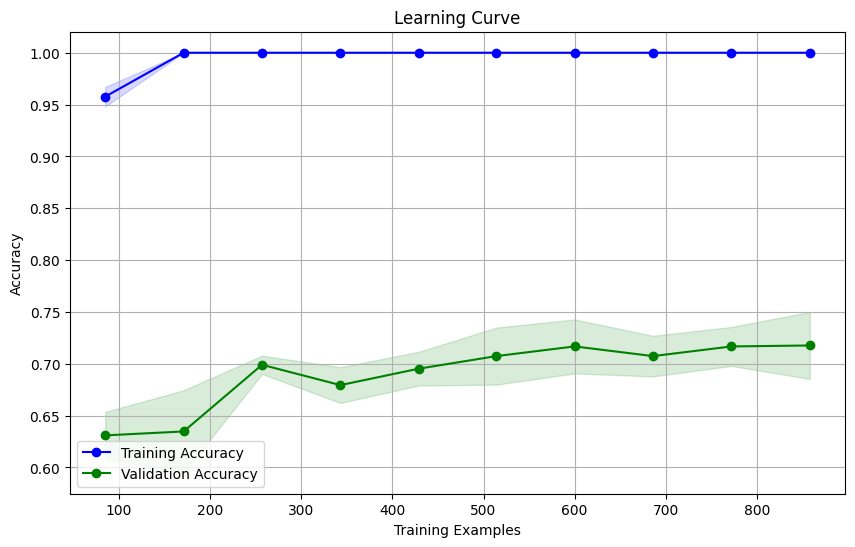

In [735]:
#  LightGBM classifier with the best hyperparameters
best_clf = lgb.LGBMClassifier(**best_params)




# Train classifier on the training data
best_clf.fit(X_train_best, y_train)

# Make predictions on the test data
y_pred = best_clf.predict(X_test_best)

# Calculate accuracy 
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Plot the learning curve
plot_learning_curve(best_clf, X_train_best, y_train)

In [736]:
# feature_importances = best_clf.feature_importances_

# #  store and display feature importances
# importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

# # Sort by importance in descending order
# importance_df = importance_df.sort_values(by='Importance', ascending=False)

In [737]:
# importance_df

In [738]:
# perm_importance = permutation_importance(best_clf, X_test, y_test, n_repeats=30, random_state=42)

# # Visualize the feature importances
# sorted_idx = perm_importance.importances_mean.argsort()[::-1]
# plt.figure(figsize=(10, 6))
# plt.bar(range(X_test.shape[1]), perm_importance.importances_mean[sorted_idx])
# plt.xticks(range(X_test.shape[1]), sorted_idx)
# plt.xlabel("Feature Index")
# plt.ylabel("Permutation Importance")
# plt.title("Permutation Feature Importance")
# plt.show()

In [739]:
best_clf.fit(X ,y)
trialll = best_clf.predict(tt)

[LightGBM] [Warning] bagging_fraction is set=0.7860507745938736, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7860507745938736


In [740]:
# final = best_clf.predict(X_test_scaled)

In [741]:
submission = pd.DataFrame({'id': test['id'], 'outcome': trialll})
submission['outcome'] = submission['outcome'].map({1:'died',0:'euthanized',2:'lived'})
submission.to_csv('submission.csv',index=False)

# XGB

In [742]:
# from hyperopt import fmin, tpe, hp
# from sklearn.model_selection import train_test_split, cross_val_score
# from mlxtend.feature_selection import PermutationImportance

In [743]:

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# space = {
#     'n_estimators': hp.choice('n_estimators', range(100, 1000)),
#     'max_depth': hp.choice('max_depth', range(1, 20)),
#     'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.3)),
#     'subsample': hp.uniform('subsample', 0.5, 1),
#     'min_child_weight': hp.choice('min_child_weight', range(1, 10)),
# }


# def objective(params):
#     model = xgb.XGBClassifier(
#         n_estimators=params['n_estimators'],
#         max_depth=params['max_depth'],
#         learning_rate=params['learning_rate'],
#         subsample=params['subsample'],
#         min_child_weight=params['min_child_weight'],
#         random_state=42,
#         tree_method='gpu_hist',  # Use GPU acceleration
#         gpu_id=0,  # Specify GPU device ID
#     )
#     score = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy').mean()
#     return -score  

# # Hyperparameter tuning with hyperopt
# best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, rstate=np.random.seed(42))


# model = xgb.XGBClassifier(
#     n_estimators=best['n_estimators'],
#     max_depth=best['max_depth'],
#     learning_rate=best['learning_rate'],
#     subsample=best['subsample'],
#     min_child_weight=best['min_child_weight'],
#     random_state=42,
#     tree_method='gpu_hist', 
#     gpu_id=0,  
# )


# model.fit(X_train, y_train)


# y_pred = model.predict(X_test)


# accuracy = accuracy_score(y_test, y_pred)
# print("Accuracy:", accuracy)


# train_sizes, train_scores, test_scores = learning_curve(
#     model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
# train_mean = np.mean(train_scores, axis=1)
# train_std = np.std(train_scores, axis=1)
# test_mean = np.mean(test_scores, axis=1)
# test_std = np.std(test_scores, axis=1)

# plt.figure(figsize=(10, 6))
# plt.plot(train_sizes, train_mean, label='Training Accuracy', marker='o', linestyle='-')
# plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15)
# plt.plot(train_sizes, test_mean, label='Validation Accuracy', marker='o', linestyle='-')
# plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15)
# plt.xlabel('Number of Training Samples')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.grid()
# plt.title('Learning Curve')
# plt.show()


# plt.figure(figsize=(10, 6))
# xgb.plot_importance(model, importance_type='weight', xlabel='Weight')
# plt.title('Feature Importance (Weight)')
# plt.show()


# permuter = PermutationImportance(model, scoring='accuracy', n_iter=10, random_state=42)
# permuter.fit(X_test, y_test)
# feature_names = X_test.columns.tolist()
# perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
# # Get feature importances
# perm_importance_scores = perm_importance.importances_mean

# # Plot permutation feature importance
# plt.figure(figsize=(10, 6))
# plt.barh(feature_names, perm_importance_scores)
# plt.xlabel('Permutation Importance (Accuracy)')
# plt.title('Permutation Feature Importance')
# plt.show()

In [744]:
# resultss=model.predict(X_test_scaled)

In [745]:
# submission = pd.DataFrame({'id': test['id'], 'outcome': resultss})
# submission['outcome'] = submission['outcome'].map({1:'died',0:'euthanized',2:'lived'})
# submission.to_csv('xgbb.csv',index=False)

#  scikit learn HistGradientBoostingClassifier 

In [746]:
# from sklearn.experimental import enable_hist_gradient_boosting
# from sklearn.ensemble import HistGradientBoostingClassifier
# # Step 1: Import the necessary libraries

# # Step 2: Split your data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Step 3: Define the objective function for Optuna
# def objective(trial):
#     params = {
#         'max_iter': trial.suggest_categorical('max_iter', [100, 200, 300]),
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
#         'max_depth': trial.suggest_categorical('max_depth', [3, 4, 5]),
#         'min_samples_leaf': trial.suggest_categorical('min_samples_leaf', [1, 2, 4]),
#     }
    
#     clf = HistGradientBoostingClassifier(random_state=42, **params)
#     clf.fit(X_train, y_train)
    
#     y_pred = clf.predict(X_test)
#     accuracy = accuracy_score(y_test, y_pred)
    
#     return accuracy

# # Step 4: Create and run the Optuna study
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100)  # You can adjust the number of trials

# # Step 5: Get the best hyperparameters and create the best model
# best_params = study.best_params
# best_model = HistGradientBoostingClassifier(random_state=42, **best_params)

# # Step 6: Fit the best model on the full training data
# best_model.fit(X_train, y_train)

# # Step 7: Calculate and print the accuracy on the test set
# y_pred = best_model.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)
# print("Best Hyperparameters:", best_params)
# print("Accuracy on Test Set:", accuracy)

# # Step 8: Plot the learning curve
# def plot_learning_curve(estimator, X, y, title=None, ylim=None, cv=None,
#                         n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
#     plt.figure()
#     if title is not None:
#         plt.title(title)
#     if ylim is not None:
#         plt.ylim(*ylim)
#     plt.xlabel("Training examples")
#     plt.ylabel("Score")

#     train_sizes, train_scores, test_scores = learning_curve(
#         estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='accuracy')
    
#     train_scores_mean = np.mean(train_scores, axis=1)
#     train_scores_std = np.std(train_scores, axis=1)
#     test_scores_mean = np.mean(test_scores, axis=1)
#     test_scores_std = np.std(test_scores, axis=1)

#     plt.grid()

#     plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
#                      train_scores_mean + train_scores_std, alpha=0.1,
#                      color="r")
#     plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
#                      test_scores_mean + test_scores_std, alpha=0.1, color="g")
#     plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
#              label="Training score")
#     plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
#              label="Cross-validation score")

#     plt.legend(loc="best")
#     return plt

# plot_learning_curve(best_model, X_train, y_train, cv=3)
# plt.show()

In [747]:
# resultssss = best_model.predict(X_test_scaled)

In [748]:
# submission = pd.DataFrame({'id': test['id'], 'outcome': resultssss})
# submission['outcome'] = submission['outcome'].map({1:'died',0:'euthanized',2:'lived'})
# submission.to_csv('asd.csv',index=False)

# simple model  ensemble

In [749]:


# from sklearn.ensemble import (
#     RandomForestClassifier,
#     GradientBoostingClassifier,
#     AdaBoostClassifier,
#     VotingClassifier,
# )


# from sklearn.svm import SVC
# from sklearn.linear_model import LogisticRegression
# from sklearn.tree import DecisionTreeClassifier
# import lightgbm as lgb




# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# def objective(trial):
 
#     n_estimators = trial.suggest_int("n_estimators", 50, 300)
#     max_depth = trial.suggest_int("max_depth", 2, 32, log=True)
#     learning_rate = trial.suggest_float("learning_rate", 0.01, 1.0, log=True)


#     model = GradientBoostingClassifier(
#         n_estimators=n_estimators,
#         max_depth=max_depth,
#         learning_rate=learning_rate,
#         random_state=42,
#     )

 
#     model.fit(X_train, y_train)

 
#     y_pred = model.predict(X_test)
#     accuracy = accuracy_score(y_test, y_pred)

#     return accuracy

# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=100) 


# best_params = study.best_params
# print("Best Hyperparameters:", best_params)

# rf = RandomForestClassifier(n_estimators=best_params["n_estimators"], random_state=42)
# svc = SVC(probability=True)
# lr = LogisticRegression(max_iter=1000)
# dt = DecisionTreeClassifier(max_depth=best_params["max_depth"], random_state=42)
# lgbm = lgb.LGBMClassifier(
#     n_estimators=best_params["n_estimators"],
#     max_depth=best_params["max_depth"],
#     learning_rate=best_params["learning_rate"],
#     random_state=41,
# )


# ensemble = VotingClassifier(
#     estimators=[
#         ("rf", rf),
#         ("svc", svc),
#         ("lr", lr),
#         ("dt", dt),
#         ("lgbm", lgbm),
#     ],
#     voting="soft",  
# )

# ensemble.fit(X_train, y_train)
# ensemble_preds = ensemble.predict(X_test)
# ensemble_accuracy = accuracy_score(y_test, ensemble_preds)
# print("Ensemble Accuracy:", ensemble_accuracy)

In [750]:
# yz = ensemble.predict(X_test_scaled)

In [751]:
# submission = pd.DataFrame({'id': test['id'], 'outcome': yz})
# submission['outcome'] = submission['outcome'].map({1:'died',0:'euthanized',2:'lived'})
# submission.to_csv('asd3.csv',index=False)

# meta ensmeble

****this meta ensemble is working "just fine" but i will keep working on trying different models with different optimizations****

In [752]:
# from sklearn.ensemble import VotingClassifier, StackingClassifier
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.naive_bayes import GaussianNB
# from sklearn.neural_network import MLPClassifier
# from xgboost import XGBClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.svm import SVC


# def objective(trial):
  
#     svc_c = trial.suggest_loguniform('svc_c', 1e-3, 1e3)
#     lr_C = trial.suggest_loguniform('lr_C', 1e-3, 1e3)
#     xgb_n_estimators = trial.suggest_int('xgb_n_estimators', 10, 500)
#     lgbm_num_leaves = trial.suggest_int('lgbm_num_leaves', 2, 50)

   
#     svc = SVC(C=svc_c, probability=True)
#     lr = LogisticRegression(C=lr_C)
#     xgb = XGBClassifier(n_estimators=xgb_n_estimators)
#     lgbm = LGBMClassifier(num_leaves=lgbm_num_leaves)

   
#     base_ensemble_1 = VotingClassifier(
#         estimators=[
#             ("svc", svc),
#             ("lr", lr),
#             ("xgb", xgb)
#         ],
#         voting="soft"
#     )

#     base_ensemble_2 = VotingClassifier(
#         estimators=[
#             ("lgbm", lgbm)
#         ],
#         voting="soft"
#     )


#     meta_ensemble = StackingClassifier(
#         estimators=[
#             ("base_ensemble_1", base_ensemble_1),
#             ("base_ensemble_2", base_ensemble_2),
          
#         ],
#         final_estimator=LogisticRegression()
#     )


#     meta_ensemble.fit(X_train, y_train)

  
#     meta_ensemble_preds = meta_ensemble.predict(X_val)

   
#     meta_ensemble_accuracy = accuracy_score(y_val, meta_ensemble_preds)

#     return meta_ensemble_accuracy


# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100)  

# best_params = study.best_params
# print("Best Hyperparameters:", best_params)


# svc = SVC(C=best_params['svc_c'], probability=True)
# lr = LogisticRegression(C=best_params['lr_C'])
# xgb = XGBClassifier(n_estimators=best_params['xgb_n_estimators'])
# lgbm = LGBMClassifier(num_leaves=best_params['lgbm_num_leaves'])


# meta_ensemble.fit(X_train, y_train)


# meta_ensemble_preds = meta_ensemble.predict(X_test)


# meta_ensemble_accuracy = accuracy_score(y_test, meta_ensemble_preds)
# print("Meta-Ensemble Accuracy:", meta_ensemble_accuracy)

In [753]:
# me=meta_ensemble.predict(X_test_scaled)

In [754]:
# submission = pd.DataFrame({'id': test['id'], 'outcome': me})
# submission['outcome'] = submission['outcome'].map({1:'died',0:'euthanized',2:'lived'})
# submission.to_csv('meta6.csv',index=False)